In [236]:
import pandas as pd

df = pd.read_csv('data.csv')

In [237]:
# Remove rows with missing values
df.dropna(inplace=True)
# Drop the TractId column as it is not needed
df.drop(['TractId'], axis=1, inplace=True)
df.drop(['County'], axis=1, inplace=True)

In [238]:
# Encode strings to integers
from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)

print(df.head(10))

   State  TotalPop   Men  Women  Hispanic  White  Black  Native  Asian  \
0      0      1192   673    745        24    863     52       0     12   
1      0      1519   941    804        11    416    545       0     10   
2      0      2732  1307   1651        80    614    265       6      7   
3      0      3614  1775   2065        96    803     71       5      2   
4      0      8670  4689   4624         9    775    164       0     31   
5      0      2967  1539   1654        30    707    251       0      0   
6      0      2767  1233   1760        40    780    137       6      0   
7      0      2260  1269   1217        42    863     71      15      0   
8      0      9101  4930   5154        14    818    153       0     10   
9      0      5514  2885   2855        10    862     97       8      3   

   Pacific  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0        0  ...     5            0          21          189       781   
1        0  ...     0            5     

In [239]:
# Divide the rows into 4 groups, with equal number of rows in each group based on the values in the column 'ChildPoverty'. And encode the child poverty value to either be 0, 1, 2, or 3.
df['ChildPoverty'] = pd.qcut(df['ChildPoverty'], 4, labels=False)
print(df.head(10))

   State  TotalPop   Men  Women  Hispanic  White  Black  Native  Asian  \
0      0      1192   673    745        24    863     52       0     12   
1      0      1519   941    804        11    416    545       0     10   
2      0      2732  1307   1651        80    614    265       6      7   
3      0      3614  1775   2065        96    803     71       5      2   
4      0      8670  4689   4624         9    775    164       0     31   
5      0      2967  1539   1654        30    707    251       0      0   
6      0      2767  1233   1760        40    780    137       6      0   
7      0      2260  1269   1217        42    863     71      15      0   
8      0      9101  4930   5154        14    818    153       0     10   
9      0      5514  2885   2855        10    862     97       8      3   

   Pacific  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0        0  ...     5            0          21          189       781   
1        0  ...     0            5     

In [240]:
print(len(df.loc[df['ChildPoverty'] == 0]))
print(len(df.loc[df['ChildPoverty'] == 1]))
print(len(df.loc[df['ChildPoverty'] == 2]))
print(len(df.loc[df['ChildPoverty'] == 3]))
print(len(df.loc[df['ChildPoverty'] == 4]))

18229
18171
18148
18170
0


In [241]:
# Split the data into features and labels
X = df.drop(['ChildPoverty'], axis=1)
y = df['ChildPoverty']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_frame, X_test_frame, y_train_frame, y_test_frame = \
    train_test_split(X, y, test_size=0.2, random_state=1)

# Convert the dataframes to numpy arrays
X_train = X_train_frame.values
X_test = X_test_frame.values
y_train = y_train_frame.values
y_test = y_test_frame.values

In [242]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(58174, 34)
(14544, 34)
(58174,)
(14544,)


In [243]:
# Create the model

import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
# Start with the following functions:
#    init
#    encode_labels
#    initialize weights
#    sigmoid
#    add bias (vector of ones)
#    objective function (cost and regularizer)
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    

In [244]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2

        return self

In [245]:
from sklearn.metrics import accuracy_score

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptron(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))


Epoch: 400/400

Accuracy: 0.25027502750275027


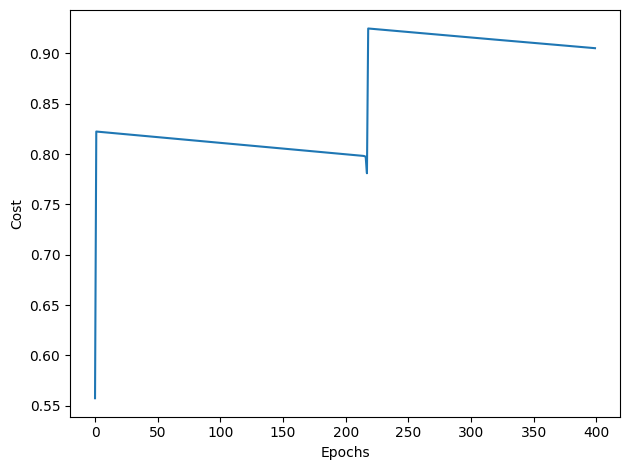

In [246]:
from matplotlib import pyplot as plt

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [247]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)


In [248]:
from sklearn.metrics import accuracy_score

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptron(**params)

nn.fit(X_train_norm, y_train, print_progress=50)
yhat = nn.predict(X_test_norm)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 400/400

Accuracy: 0.3169004400440044


In [249]:
# Use one hot encoding for the labels

In [250]:
# Print the column names
print(X.columns)

Index(['State', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')


In [251]:
# One hot encode the labels
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)


In [252]:
encode_and_bind(X, 'State')

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)


In [253]:
from sklearn.model_selection import train_test_split

X_train_frame, X_test_frame, y_train_frame, y_test_frame = \
    train_test_split(X_norm, y, test_size=0.2, random_state=1)

# Convert the dataframes to numpy arrays
X_train = X_train_frame
X_test = X_test_frame
y_train = y_train_frame
y_test = y_test_frame
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(58174, 34)
(14544, 34)
(58174,)
(14544,)


In [254]:
from sklearn.metrics import accuracy_score

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptron(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))



Epoch: 400/400

Accuracy: 0.3140814081408141


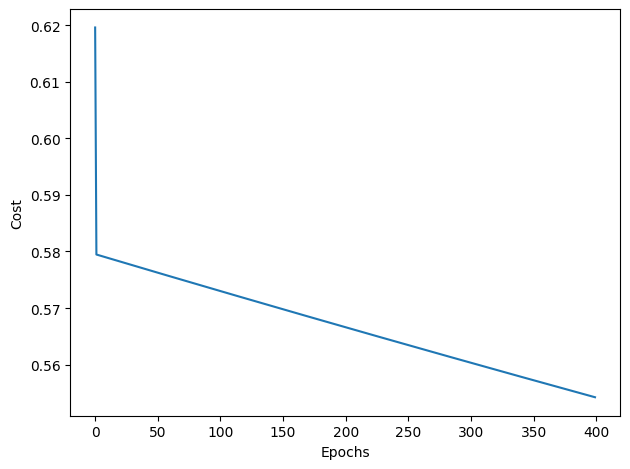

In [255]:
from matplotlib import pyplot as plt

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [256]:
# Try with scikit
from sklearn.neural_network import MLPClassifier
params = dict(hidden_layer_sizes=(30), 
              alpha=0.1, # tradeoff L2 regularizer
              max_iter=400, # iterations
              learning_rate_init=0.001,  # learning rate
              random_state=1)

nn = MLPClassifier(**params)

nn.fit(X_train, y_train)

yhat = nn.predict(X_test)

print('Accuracy:',accuracy_score(y_test,yhat))

Accuracy: 0.7418179317931793


In [257]:
print(X_train[0])

[ 1.3017512   0.37756428  0.06435835  0.63407181  0.63753587 -1.85573584
  2.29114991 -0.22661465 -0.50920366 -0.17967672 -0.3544377  -1.41844605
 -1.38862083 -1.26923601 -1.03349081  1.33578704 -1.44000958  2.35588601
 -0.28888303  0.70354925  0.06325437  0.36225803 -0.18113726 -0.06609842
 -0.45028719  0.09023218 -0.43457759  0.0170304   0.31240149  0.41449322
 -0.24500979 -0.38757705 -0.38837095  1.53613322]


In [258]:
class TLPBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

class TLPMiniBatch(TLPBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                
                
                # simple momentum calculations
                
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

In [260]:
from sklearn.metrics import accuracy_score

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              shuffle=True,
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.01, # poor starting learning rate!!
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn = TLPMiniBatch(**vals)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

KeyError: '[44709, 27981, 38301, 27904, 56533, 33878, 22652, 56643, 36512, 57850, 29842, 36650, 15893, 48432, 1599, 32224, 27390, 56262, 9598, 2730, 40661, 7189, 13964, 31263, 39879, 49814, 27299, 47259, 1547, 21470, 19649, 21384, 16222, 26536, 6756, 32341, 48037, 20543, 28113, 44742, 55453, 12302, 28898, 46109, 53081, 39287, 9187, 47949, 43489, 54494, 43389, 52195, 51275, 20839, 23794, 58059, 28448, 43868, 23779, 16314, 13014, 10119, 5435, 50477, 23198, 32466, 27302, 51768, 19746, 11034, 31635, 58162, 11652, 6401, 15632, 21822, 14829, 2107, 12033, 51465, 2020, 19223, 53228, 52523, 21113, 7952, 58122, 19205, 52610, 55763, 13751, 47783, 24928, 18345, 50667, 12401, 41647, 5303, 33229, 42969, 17589, 9974, 5235, 26098, 24081, 37062, 49745, 9694, 46928, 15666, 46833, 47196, 3249, 25454, 11616, 10666, 17779, 33530, 41252, 57201, 48914, 30745, 13899, 6075, 40781, 16822, 17663, 13159, 37780, 47125, 43583, 5034, 54783, 36693, 47401, 2787, 11108, 52322, 2058, 994, 29698, 19189, 18373, 19678, 22168, 32670, 5806, 41686, 8391, 26603, 21176, 23564, 48081, 28744, 22669, 56494, 18842, 40973, 25406, 8358, 21908, 46144, 49236, 45525, 7373, 42703, 16452, 13823, 27492, 3920, 56848, 45782, 23593, 6990, 50572, 28789, 11713, 30569, 50897, 41269, 13049, 3027, 25462, 23121, 36961, 37892, 51587, 53603, 54314, 13543, 30590, 44827, 9322, 18347, 19582, 19323, 49994, 13792, 47970, 13151, 16379, 35079, 27180, 15126, 11541, 28684, 29582, 8940, 38150, 52318, 36415, 31651, 8779, 53156, 46328, 15190, 9373, 29578, 38195, 50617, 11007, 45604, 31497, 53925, 26977, 10513, 9988, 36228, 41895, 44209, 32248, 30972, 12391, 108, 38532, 37061, 48549, 45356, 40149, 43396, 24463, 29308, 46143, 33567, 24588, 42784, 31253, 33544, 22999, 706, 24570, 42833, 55872, 6982, 8257, 29201, 1578, 38308, 39851, 6927, 10212, 32244, 57139, 46120, 37797, 55313, 17583, 10189, 42582, 13644, 49775, 10378, 29741, 56809, 45215, 6230, 21648, 52856, 2969, 53106, 10745, 29744, 47901, 3971, 42380, 54007, 26606, 29641, 29658, 6142, 51327, 46585, 40371, 6835, 39592, 16975, 34582, 47597, 12817, 9660, 47332, 461, 27424, 10204, 52148, 55026, 15169, 888, 6069, 30253, 26154, 2223, 1967, 48454, 48626, 24320, 24941, 23330, 8067, 27784, 45527, 37616, 49659, 4943, 23874, 12704, 17008, 6491, 42802, 29043, 35497, 27891, 38056, 52178, 44911, 2852, 49581, 53429, 5693, 516, 26575, 21423, 36294, 53176, 24734, 38974, 10, 32661, 27441, 9053, 1840, 49140, 46471, 17991, 19617, 31195, 24943, 24366, 30583, 46352, 21687, 50892, 15980, 28142, 25907, 35193, 55389, 44783, 11677, 57013, 5126, 18409, 50219, 55155, 22463, 46658, 15228, 38912, 31104, 35425, 22847, 2528, 3325, 57917, 15173, 19949, 27137, 38641, 35161, 57020, 34371, 56150, 18163, 49637, 17331, 46372, 28972, 5669, 48195, 53571, 4185, 14121, 22620, 39411, 25937, 3079, 13637, 15586, 15691, 32158, 11746, 22859, 36029, 51788, 12129, 6024, 52009, 42324, 2684, 18312, 35040, 15574, 8684, 18863, 17217, 53066, 34774, 42104, 46504, 14426, 52060, 4939, 8720, 10719, 37759, 47244, 15712, 58138, 26687, 8212, 3094, 50325, 33934, 55420, 11101, 33635, 41573, 31285, 46959, 49229, 33762, 6313, 48373, 21309, 52363, 52478, 54469, 55045, 5856, 35496, 12087, 1575, 18402, 51876, 46664, 18325, 3437, 16294, 41807, 27998, 33294, 27143, 35494, 43675, 15731, 46527, 19077, 4934, 51067, 4127, 37918, 48204, 55404, 20654, 22222, 9699, 47917, 4160, 50539, 195, 13102, 28683, 20660, 36859, 9071, 15876, 54981, 28528, 45031, 7455, 15668, 37078, 28589, 6108, 52316, 17330, 5510, 28527, 26862, 1854, 3847, 12718, 4704, 38061, 53201, 31452, 12599, 28254, 22067, 51727, 2270, 25932, 14678, 52005, 24815, 53641, 49821, 19902, 1856, 655, 15904, 4627, 49209, 50891, 8463, 57276, 51683, 13412, 38853, 45252, 11069, 8820, 14799, 52067, 42963, 32703, 28, 30452, 42701, 1477, 41106, 42357, 5206, 48493, 26312, 52948, 33881, 56234, 10208, 15372, 32745, 51584, 43244, 9048, 21574, 49226, 24684, 36849, 26047, 11787, 29359, 1363, 36366, 12665, 31075, 28809, 29656, 50560, 30, 51436, 30778, 14879, 41814, 10139, 10104, 55700, 8716, 6544, 13058, 36375, 36340, 2714, 3334, 25715, 34766, 14967, 25416, 25735, 32632, 18276, 51466, 2452, 8698, 47467, 4752, 14394, 1850, 27312, 55630, 36409, 28708, 21563, 46831, 10882, 54511, 37154, 18657, 21349, 9608, 51180, 36993, 17984, 40372, 199, 55977, 51177, 44727, 6450, 5168, 18165, 49998, 43101, 29331, 9812, 13811, 49924, 31340, 10595, 54147, 35287, 38236, 50965, 51386, 8051, 42372, 22870, 36383, 50506, 48695, 27770, 43628, 23478, 30929, 15430, 38812, 46957, 48314, 20914, 10580, 37264, 38420, 44326, 30457, 55435, 17002, 19282, 6737, 40590, 31383, 7056, 19872, 45803, 57903, 2160, 6869, 11318, 25002, 52795, 19321, 6477, 11150, 12850, 37752, 45831, 48583, 56223, 19599, 25546, 36939, 1346, 17045, 20059, 27233, 9817, 7500, 30069, 20968, 35414, 26296, 38958, 46894, 39523, 50377, 17294, 22531, 5528, 34942, 10116, 54761, 27083, 26656, 19532, 25734, 44422, 56892, 35110, 30984, 9280, 10168, 9461, 37931, 29494, 50941, 5896, 55490, 15705, 36879, 44571, 36564, 32658, 36517, 56794, 53987, 42717, 27897, 57718, 55223, 19102, 23575, 56822, 40406, 4178, 24793, 12281, 41103, 2953, 7363, 4974, 14683, 2853, 20479, 41281, 35320, 20789, 20614, 38772, 18321, 11109, 21550, 57185, 9624, 36869, 20663, 57025, 54980, 13321, 47996, 58131, 47475, 47681, 56625, 47886, 18547, 27175, 32449, 20816, 36171, 48418, 46913, 18051, 52310, 1356, 38782, 39678, 53053, 2954, 50111, 27927, 38257, 14913, 18424, 41131, 10451, 619, 34664, 14797, 22963, 29014, 34196, 35644, 6270, 6182, 46365, 487, 1131, 54246, 52343, 7304, 51757, 50103, 37828, 4035, 15722, 16733, 37166, 40385, 56402, 29793, 56613, 10834, 38886, 8080, 39822, 8581, 45705, 433, 28191, 23945, 15471, 22043, 46805, 50976, 2649, 46013, 20150, 2914, 16384, 40511, 51246, 56470, 12967, 12818, 1330, 21252, 23568, 46291, 11585, 38811, 18061, 12782, 49954, 42298, 28855, 29049, 17923, 17058, 31063, 6151, 14800, 51014, 6559, 41565, 45729, 1541, 48007, 1299, 15031, 2525, 55736, 8828, 923, 33741, 47037, 29914, 48845, 26705, 51265, 54517, 43948, 1045, 369, 14971, 40427, 14594, 29935, 19835, 11957, 48016, 35537, 1141, 13907, 36420, 55401, 14403, 9880, 32460, 25424, 2056, 23968, 2582, 12943, 21045, 21003, 11561, 2055, 37129, 57583, 39646, 31389, 51306, 34886, 738, 32787, 32623, 23586, 17163, 28432, 18577, 32771, 56164, 13122, 29897, 44875, 52040, 49526, 15401, 8338, 39894, 42691, 16140, 18782, 29529, 12180, 15459, 27955, 32507, 32354, 23217, 30544, 19981, 13716, 3693, 55859, 16996, 41159, 6221, 44621, 14213, 29016, 3980, 48289, 10705, 29856, 28318, 14030, 32200, 40390, 24066, 32042, 24174, 25872, 2909, 30417, 9143, 50160, 42773, 16518, 55229, 55425, 6475, 5666, 23252, 56734, 42328, 30256, 50852, 23955, 50391, 1239, 36339, 13025, 10801, 19386, 13146, 28643, 15441, 29452, 50764, 32239, 30912, 25788, 56254, 51220, 42602, 16549, 5372, 43713, 7149, 25759, 24007, 40416, 14714, 17388, 13180, 33930, 17549, 51049, 14582, 47536, 29152, 44534, 2616, 38451, 40268, 8639, 2219, 11669, 752, 7536, 36027, 33296, 41929, 43886, 52666, 28613, 53536, 43927, 40807, 28280, 15402, 39459, 28110, 17542, 53261, 39955, 2770, 32432, 219, 196, 44082, 45748, 7167, 9516, 16949, 25052, 2788, 55172, 23536, 55959, 25610, 20534, 55224, 19852, 16596, 19377, 13707, 25730, 50331, 38879, 52208, 20596, 41064, 41942, 19034, 46136, 51421, 48623, 34107, 42787, 46091, 27009, 9711, 4364, 27322, 48676, 50696, 24825, 33204, 41033, 43898, 47603, 33513, 36521, 18509, 35487, 19859, 36387, 53545, 49794, 38786, 20317, 35670, 51324, 27201, 3097, 15560, 19382, 39397, 7955, 19565, 23617, 10755, 3317, 42092, 40193, 19797, 3983, 1132, 30316, 42391, 9766, 9311, 31909, 31709, 26751, 32527, 31, 10942, 14040, 19229, 13889, 45319, 20327, 4990, 35348, 34517, 23820, 13982, 8149, 18606, 43487, 54363, 18322, 3357, 32262, 34473, 25119, 36971, 1813, 40086, 15234, 58109, 46590, 5091, 27437, 25352, 2895, 25253, 11102, 26186, 40130, 21837, 45278, 25948, 52502, 43477, 32037, 38441, 55697, 2942, 9978, 30693, 32329, 30028, 52319, 33024, 7900, 54914, 25313, 4915, 49718, 24229, 42161, 33401, 4272, 29603, 32163, 16167, 10633, 426, 36682, 6137, 51553, 39051, 44465, 25484, 4968, 15218, 19938, 22716, 15751, 55114, 115, 43478, 24057, 50978, 18788, 54111, 10369, 47040, 3566, 13315, 15324, 6557, 29610, 33749, 41143, 43334, 12213, 3245, 38273, 21015, 28015, 56583, 12569, 31274, 33502, 20228, 23535, 4255, 2904, 39711, 6060, 43228, 20900, 37038, 58041, 12528, 36716, 41391, 39138, 17702, 7680, 34618, 29479, 51644, 55512, 45961, 26503, 15554, 3132, 12283, 31761, 51437, 43550, 43104, 27032, 18214, 23980, 46307, 9328, 32569, 50054, 13862, 33334, 12557, 42505, 4509, 45353, 30149, 43612, 29093, 14943, 40202, 14317, 24429, 19407, 49200, 13601, 22023, 48026, 17212, 55417, 32566, 35884, 22944, 1266, 54850, 17261, 2970, 38496, 46084, 17445, 36113, 6897, 26901, 46800, 33661, 38536, 37057, 12055, 42223, 34154, 4528, 44810, 35009, 23505, 49962, 53069, 7863, 17452, 42325, 22813, 32133, 16901, 7584, 27958, 36062, 46211, 31035, 46137, 21833, 3917, 26976, 6025, 20254, 2081, 50074, 29962, 15394, 13932, 6895, 6181, 51448, 18999, 29456, 4720, 42570, 27353, 29735, 33364, 43737, 22217, 18287, 57249, 11591, 31570, 41202, 23962, 15440, 21416, 42136, 43654, 25643, 24348, 6797, 41715, 41790, 3517, 5240, 42628, 31559, 49171, 42721, 27953, 5312, 48922, 20148, 4785, 1000, 23482, 7529, 30950, 2046, 54545, 2224, 35821, 542, 9808, 4211, 6955, 29177, 7724, 50708, 39023, 12238, 40897, 16381, 38926, 89, 56970, 25125, 53488, 45809, 8490, 1484, 2573, 19170, 25062, 21691, 12700, 14828, 10947, 23532, 18438, 4926, 47947, 47950, 4733, 51442, 15039, 28052, 20485, 34841, 35959, 156, 20242, 25427, 54660, 20822, 49130, 54221, 26578, 48550, 23402, 45320, 16799, 53590, 21724, 44042, 55867, 49870, 11724, 10770, 22822, 26020, 21934, 18230, 33120, 7870, 50861, 16771, 12257, 30084, 1827, 57599, 27116, 37335, 9964, 57809, 53194, 1118, 44497, 45367, 44849, 44228, 38215, 9716, 12619, 2599, 30073, 1933, 36779, 17297, 5601, 15844, 15235, 32802, 6655, 57522, 13352, 46713, 56562, 46047, 252, 35939, 32719, 51527, 16428, 31111, 8370, 5776, 19468, 11285, 51863, 12404, 9209, 58110, 11434, 48521, 6402, 44434, 423, 39790, 192, 57720, 47652, 21059, 29865, 21582, 54874, 8014, 54860, 11892, 7259, 36557, 52257, 52422, 50983, 9704, 28949, 39407, 6803, 12878, 26269, 45572, 57029, 9193, 45014, 11516, 26612, 30019, 36872, 38353, 3921, 39564, 38113, 23892, 57383, 18022, 17961, 48945, 20963, 37833, 15385, 55170, 11602, 7049, 21619, 4860, 6192, 12874, 5620, 9392, 28470, 30443, 28946, 16978, 20521, 51615, 8736, 52073, 45665, 19421, 35978, 48010, 14425, 53710, 55100, 55166, 7065, 52774, 32876, 27883, 44335, 20603, 3750, 39108, 13217, 52830, 8660, 58154, 24283, 26068, 40574, 57628, 49336, 5888, 40862, 8609, 17301, 7534, 3394, 23105, 8678, 42574, 16354, 21597, 14627, 10064, 45296, 1587, 11960, 17735, 16946, 48920, 5696, 49815, 12436, 43789, 28903, 36698, 55695, 50683, 5770, 49945, 41632, 4126, 47709, 43418, 633, 39191, 19065, 52852, 44338, 21033, 51789, 17113, 31942, 14107, 19002, 14716, 58173, 50962, 15186, 53869, 25699, 41208, 18754, 8384, 34527, 44354, 6822, 8699, 50624, 29516, 22425, 56487, 9710, 7252, 35192, 40059, 44295, 3439, 11870, 46609, 22791, 35341, 20767, 47626, 56594, 8341, 21878, 24139, 42249, 34536, 46386, 58144, 9635, 50814, 19554, 23512, 12914, 2957, 35539, 15566, 5188, 11397, 33836, 15361, 43892, 52124, 57769, 40622, 47144, 19839, 9670, 28899, 5861, 39964, 49103, 1225, 42455, 27165, 8948, 33827, 15563, 34814, 37070, 28467, 10677, 16066, 53552, 19819, 49186, 25854, 10855, 13371, 35492, 13225, 20588, 34703, 37260, 25122, 722, 13624, 41863, 3300, 32775, 54720, 19583, 43132, 21055, 45998, 11038, 54172, 107, 23038, 12627, 1251, 16263, 55254, 3521, 25118, 53405, 35812, 30198, 37577, 12209, 2077, 43371, 8555, 8493, 38284, 17607, 49411, 39378, 40437, 10991, 9128, 25270, 58078, 9414, 24172, 13905, 22142, 41748, 36268, 1191, 10669, 44191, 24823, 41140, 12836, 35830, 585, 52220, 9540, 32380, 47957, 27816, 49516, 29534, 19272, 40544, 24791, 14914, 4679, 27340, 11166, 20284, 391, 54491, 10041, 34627, 51045, 11387, 19361, 45509, 32727, 15073, 14880, 38446, 47201, 22938, 25333, 24089, 45917, 1254, 50555, 815, 12319, 41129, 32692, 8675, 4317, 7063, 18962, 53224, 55780, 48293, 19704, 49384, 14349, 38086, 22518, 15856, 3982, 16333, 54915, 22683, 2195, 57321, 17358, 4557, 43213, 40317, 32513, 57233, 54851, 3903, 10274, 12354, 32217, 54948, 35116, 25003, 43756, 5609, 12183, 36556, 47334, 3881, 31518, 36216, 48743, 7275, 55531, 24422, 32062, 7578, 2089, 15656, 45397, 41210, 3049, 807, 5100, 25306, 32751, 19149, 47256, 11021, 25508, 19420, 35560, 27968, 13768, 43103, 7735, 57708, 38645, 8513, 7320, 49014, 22871, 30558, 49599, 18984, 39485, 10857, 43514, 40722, 22301, 15030, 39262, 28967, 24421, 38384, 48477, 39717, 929, 15347, 10622, 22985, 38807, 9293, 3261, 54745, 51276, 32285, 34996, 46964, 11625, 5685, 5734, 35025, 39062, 20615, 16122, 50411, 8066, 33668, 13660, 603, 19117, 46401, 50366, 6370, 24170, 36084, 57068, 36127, 30658, 753, 24762, 46293, 5665, 1306, 19111, 52042, 20566, 1585, 28862, 25032, 37447, 19763, 10099, 23916, 13912, 25079, 3819, 15592, 9995, 14083, 19271, 12389, 55658, 53006, 4416, 40235, 1205, 26006, 23465, 31930, 57915, 1718, 21617, 7089, 20217, 29820, 34960, 20341, 11370, 54104, 43684, 29028, 24418, 9090, 43664, 24143, 48175, 41430, 46122, 36703, 15189, 46971, 31073, 32333, 36514, 33339, 39674, 41464, 18616, 20857, 29021, 54408, 31745, 6806, 39605, 25482, 8808, 42739, 56888, 4975, 4503, 3222, 12821, 54891, 1196, 1077, 6960, 52304, 32965, 35630, 14007, 25909, 24358, 21737, 31832, 54594, 33576, 31374, 8142, 6304, 31494, 15657, 57072, 19143, 30027, 7318, 55667, 39078, 18067, 47363, 4664, 43158, 7157, 16476, 48955, 52743, 24072, 49489, 49134, 6919, 22363, 55785, 13135, 16683, 32824, 3315, 1481, 41613, 10615, 42723, 19023, 13918, 27243, 14667, 7526, 39772, 21375, 14766, 31875, 16925, 12698, 44312, 4280, 12158, 37813, 49087, 7271, 35306, 15391, 38209, 5555, 23349, 2981, 4439, 15878, 5500, 1226, 31608, 14881, 40482, 38607, 12993, 1860, 34755, 49609, 52741, 47387, 43649, 5810, 45901, 39696, 50461, 47241, 2932, 49607, 19987, 43949, 50725, 35241, 14849, 5737, 21723, 54727, 321, 48903, 47157, 48492, 4444, 15857, 29439, 8123, 45579, 21163, 36192, 16892, 8560, 25307, 46771, 4207, 6226, 32247, 7380, 54448, 32427, 51186, 10564, 40014, 25615, 47746, 46893, 44587, 4984, 15988, 20795, 49531, 48144, 12508, 43668, 42344, 44667, 55693, 46222, 45562, 55112, 47176, 28060, 41232, 24863, 14853, 57130, 3065, 3497, 21186, 11245, 6850, 15353, 33187, 27996, 22735, 13110, 34592, 38614, 13234, 13685, 56076, 22795, 42218, 55743, 2181, 41751, 28873, 14097, 8168, 31217, 43749, 27877, 32858, 50256, 30072, 7476, 39452, 52490, 4948, 37761, 34598, 16738, 26710, 12290, 51909, 3545, 54319, 5142, 47494, 45145, 24855, 35191, 15552, 47073, 54807, 23125, 18482, 4165, 40600, 16025, 48119, 13580, 45030, 5149, 32462, 5977, 45735, 49458, 17005, 2350, 21086, 56221, 14823, 15781, 36480, 7314, 56065, 46700, 21178, 2041, 20595, 23262, 44760, 6416, 55692, 55128, 20396, 20562, 106, 51139, 12472, 55757, 16743, 44776, 10397, 22397, 27937, 54359, 39392, 20902, 21786, 41550, 24484, 12447, 33461, 54644, 23401, 15004, 3593, 7740, 43380, 35894, 6478, 26894, 7240, 45868, 36408, 31880, 43388, 28647, 33376, 33711, 44899, 18483, 22407, 9194, 36737, 14217, 54378, 5186, 33755, 26740, 34321, 2123, 16861, 4865, 30946, 56303, 32770, 15229, 5560, 8373, 37470, 55105, 20357, 16400, 30655, 24459, 25294, 44237, 35656, 9054, 27530, 44325, 35254, 32204, 7570, 18075, 11170, 58054, 45510, 42077, 8482, 43346, 56931, 30137, 34053, 23768, 52885, 43996, 56432, 12431, 4275, 40441, 34873, 30704, 6005, 29883, 33725, 7051, 32510, 50848, 5242, 2235, 57316, 16674, 56107, 125, 19096, 38835, 6348, 52379, 43165, 21512, 2558, 9860, 40567, 13171, 53556, 57467, 15760, 12, 9921, 20043, 50091, 39928, 33774, 47943, 45667, 23266, 53119, 34015, 12548, 7575, 31311, 37138, 41003, 29101, 5423, 39435, 3808, 48874, 54316, 16964, 37011, 31014, 2369, 36658, 31411, 20231, 5589, 10618, 40320, 15099, 28821, 21327, 42346, 22879, 19685, 45481, 51081, 53071, 16447, 13353, 28788, 39552, 8466, 23003, 55325, 3854, 54691, 20353, 46310, 3031, 33213, 28252, 21479, 47793, 14671, 13529, 32537, 33068, 52873, 6289, 46980, 36205, 8173, 18575, 23632, 5417, 7182, 6711, 9145, 32300, 16883, 54503, 50212, 45490, 40681, 27443, 44123, 2629, 56834, 43321, 50964, 35711, 47910, 16065, 659, 47862, 8806, 23288, 1785, 10871, 45552, 28446, 25058, 40917, 42648, 49437, 20622, 4011, 54379, 40024, 53976, 8520, 57996, 15481, 23337, 42158, 20600, 51806, 41651, 19656, 37170, 46017, 10880, 17553, 5824, 28690, 38237, 15382, 34705, 16375, 11536, 46733, 3297, 15603, 10221, 4038, 25593, 52632, 23313, 27764, 15015, 53410, 48592, 7676, 43226, 9343, 27205, 45348, 23415, 56313, 1340, 5730, 189, 10482, 6274, 6760, 32047, 23286, 53037, 8867, 2817, 7378, 44017, 57998, 57536, 22967, 2371, 27711, 4066, 3021, 15362, 55874, 35652, 18117, 43471, 2871, 39053, 57859, 37578, 26402, 6533, 36332, 54918, 49041, 43609, 12867, 3811, 6052, 22290, 4800, 4537, 48847, 11022, 9329, 52157, 5599, 25389, 55345, 50263, 20126, 47251, 4471, 53966, 13384, 48226, 31866, 54346, 45838, 16300, 643, 6587, 40420, 10572, 35957, 29694, 52456, 10841, 27673, 52844, 8322, 7859, 10685, 25685, 54301, 18652, 6636, 56965, 43556, 4318, 42795, 25590, 58102, 13510, 44987, 4684, 26528, 29382, 33331, 44953, 43784, 30330, 986, 28489, 20987, 27887, 22439, 19943, 40203, 14311, 25167, 42707, 37358, 10419, 944, 32123, 1645, 16615, 4764, 46261, 34722, 46975, 44436, 30710, 54888, 51247, 46987, 2327, 26995, 44511, 28452, 44382, 41789, 35950, 24315, 14674, 28729, 27132, 41783, 14935, 9201, 22298, 2847, 4784, 24487, 34666, 11472, 129, 44546, 40294, 30957, 46179, 50830, 47635, 40697, 51380, 41699, 43268, 17960, 26487, 22496, 7902, 31615, 43054, 29574, 46319, 10432, 26773, 11647, 26915, 32947, 13695, 12400, 13937, 13139, 34534, 44284, 46237, 11955, 230, 40589, 25997, 39732, 6857, 48933, 21853, 2861, 24333, 50595, 4573, 41235, 35044, 25493, 55333, 26093, 39436, 44251, 50255, 25195, 13900, 30935, 56503, 21956, 48172, 39268, 12566, 16915, 27194, 9116, 36325, 53383, 54576, 40839, 29120, 11725, 34981, 30659, 36003, 31502, 6430, 45694, 15360, 9728, 19490, 10165, 18499, 31677, 54092, 53444, 8172, 13019, 14805, 14509, 43921, 54388, 4373, 19707, 2692, 44929, 11172, 40545, 10346, 42510, 32278, 12723, 27442, 1313, 21382, 12945, 46993, 5152, 33901, 33969, 36187, 48106, 22283, 11844, 42178, 28835, 6190, 42260, 43010, 9364, 36708, 55161, 17281, 36123, 38400, 27114, 7102, 5336, 4847, 55013, 17386, 14820, 27793, 53437, 29350, 32316, 5279, 56959, 41354, 30564, 31901, 39636, 33611, 9273, 5626, 17409, 14457, 24183, 18708, 30190, 44850, 34436, 15310, 46178, 47525, 47829, 39782, 47090, 23472, 33915, 55982, 42347, 35926, 20591, 7268, 23706, 25550, 5926, 14737, 36714, 1124, 20813, 52203, 22651, 22696, 55759, 18327, 29589, 20472, 32840, 32223, 53241, 14710, 12716, 4166, 2301, 55381, 51770, 39007, 2002, 19611, 56849, 56645, 6318, 25, 44116, 21319, 49900, 54864, 44468, 20286, 7711, 8946, 29239, 2851, 5836, 234, 30276, 19814, 28616, 46387, 20343, 16585, 48782, 54748, 36093, 6860, 35444, 46911, 7260, 55896, 26442, 40978, 21840, 47343, 58113, 36232, 44069, 21230, 55177, 44007, 4566, 13608, 48074, 15768, 25461, 21325, 55671, 18474, 15021, 14162, 42516, 57153, 45166, 28162, 48169, 50482, 6420, 14944, 4282, 22742, 12547, 43761, 17122, 36974, 43483, 23710, 30934, 17300, 4490, 45832, 44092, 12757, 24030, 28501, 28411, 29840, 28396, 33372, 41273, 25698, 29765, 29780, 44883, 41055, 11032, 15222, 41720, 29707, 57315, 14158, 16804, 52372, 1235, 4978, 31648, 35307, 17631, 40154, 44438, 3502, 14054, 48496, 20885, 3196, 33256, 28648, 16927, 47352, 3686, 36880, 28303, 45696, 44348, 8175, 49212, 7199, 35854, 25849, 23721, 37693, 53921, 12160, 8647, 39707, 52998, 4398, 42301, 44385, 37573, 17790, 13987, 24919, 48035, 22746, 43931, 35312, 20196, 35546, 21234, 36838, 11708, 49435, 1699, 18269, 42896, 22750, 4202, 37584, 15641, 48888, 24095, 8516, 4489, 34974, 50783, 43186, 3177, 10795, 23772, 16321, 18539, 13699, 40214, 30700, 5297, 29830, 48463, 9195, 54252, 19174, 35442, 51137, 10409, 32391, 44698, 207, 33706, 36255, 47915, 14530, 50291, 18205, 5002, 27866, 50022, 6059, 9927, 21507, 48216, 29817, 56276, 31166, 10452, 6294, 42401, 29137, 41304, 22558, 49472, 6789, 44896, 51647, 3337, 36905, 4598, 37279, 57949, 32522, 14092, 21165, 46175, 13214, 56148, 9823, 39995, 6145, 53249, 52327, 13177, 10916, 30638, 54794, 57406, 26847, 7244, 29506, 20845, 49026, 1035, 1627, 42160, 9285, 23122, 46522, 50163, 8785, 51707, 46952, 40533, 25598, 54606, 44212, 2478, 43484, 23282, 54937, 48431, 5061, 31732, 46002, 58095, 56530, 23849, 5694, 29831, 17219, 33175, 29475, 47162, 27087, 41359, 51264, 15593, 22251, 47243, 7213, 3621, 31039, 45683, 41744, 44615, 57165, 33492, 11614, 32009, 175, 57420, 8792, 20692, 26544, 9613, 55416, 28497, 10688, 37648, 56815, 30998, 56518, 3102, 39368, 28232, 19279, 29465, 15493, 15102, 35300, 53380, 46549, 10531, 13204, 5948, 4492, 8008, 32803, 3389, 364, 53453, 19469, 9486, 57058, 26396, 48603, 23704, 41987, 48899, 35720, 43766, 9586, 33304, 49527, 3462, 29712, 55373, 54963, 18532, 41032, 4753, 8430, 55578, 34134, 48028, 48367, 6486, 21931, 20913, 41373, 18109, 1988, 51721, 43558, 53730, 11774, 54967, 41928, 45324, 16891, 31473, 21271, 28540, 28928, 20657, 2150, 21435, 197, 4241, 33688, 32673, 285, 19806, 18334, 2717, 8333, 42247, 39371, 6853, 19705, 2290, 15616, 7348, 13604, 41822, 38713, 20045, 18633, 6449, 6503, 10483, 27965, 35206, 42866, 5118, 42208, 29323, 18604, 15295, 19337, 48690, 53400, 34181, 8519, 5453, 40094, 46362, 53823, 33767, 24289, 9938, 29941, 4061, 19663, 9900, 30489, 51582, 52670, 5498, 37137, 41319, 25274, 52018, 39867, 15443, 28349, 24491, 54928, 42205, 24944, 27177, 48880, 56485, 6642, 57912, 47570, 6989, 11991, 22565, 38950, 54267, 28828, 2133, 45064, 34082, 47135, 9119, 33920, 50591, 7073, 15775, 12000, 53140, 24474, 48768, 55988, 49331, 7556, 16736, 26331, 2543, 56358, 57761, 44045, 1920, 36252, 17204, 23113, 30466, 40113, 57677, 42304, 18733, 41695, 43235, 19957, 9357, 3552, 37989, 31692, 29330, 57861, 31444, 54830, 19555, 5292, 24501, 53993, 10247, 52835, 14659, 14555, 4979, 22919, 39483, 58065, 702, 9080, 27104, 7856, 55815, 13636, 1518, 16561, 14964, 18194, 16684, 55919, 24046, 5873, 47058, 28034, 27734, 40904, 5496, 50518, 40962, 28651, 50732, 7150, 55307, 55880, 28496, 46065, 58006, 47916, 25382, 46569, 7699, 20347, 26414, 54749, 28812, 37180, 37981, 8752, 22132, 7709, 55544, 25036, 36481, 22184, 35585, 9339, 25243, 20467, 51250, 42923, 1513, 52693, 23898, 1476, 13969, 32325, 29960, 27059, 16132, 2762, 53042, 39970, 30996, 35578, 25583, 2487, 57889, 49023, 4300, 16469, 2711, 5458, 56753, 26948, 44797, 12061, 17710, 57486, 57986, 45237, 22665, 51889, 45463, 27329, 35631, 17401, 5317, 18549, 51046, 53280, 27746, 43121, 38673, 54409, 15868, 16453, 17921, 28483, 22485, 24132, 58070, 25157, 25645, 29199, 45978, 54931, 5815, 6712, 8406, 48931, 54119, 29739, 30359, 56244, 4248, 7535, 1444, 18179, 34551, 21343, 15652, 23624, 24838, 39776, 23788, 3449, 18896, 17810, 3841, 31203, 44492, 57379, 2300, 22996, 26040, 7184, 18861, 11432, 19487, 43135, 55574, 29773, 19885, 30705, 37347, 50640, 24970, 16633, 31496, 26542, 37793, 9874, 5853, 30904, 15810, 28065, 2382, 40942, 28307, 23107, 35558, 6620, 40287, 15649, 10366, 34739, 56994, 28216, 505, 36711, 54685, 54971, 44914, 2575, 395, 34240, 10153, 46313, 48374, 25920, 7067, 4570, 45900, 14296, 1807, 21800, 43849, 7698, 26939, 6132, 18281, 33096, 30122, 239, 41679, 28748, 12826, 57694, 3331, 555, 47127, 49716, 9062, 41244, 18411, 31201, 12003, 28965, 23173, 11371, 13631, 46766, 33273, 35423, 28545, 51340, 39377, 41075, 51763, 50777, 2733, 1773, 9284, 6495, 21653, 29906, 42841, 617, 42000, 56120, 41297, 13508, 53373, 17757, 45793, 13054, 49330, 21521, 22711, 48282, 24897, 14151, 26959, 12210, 15576, 50942, 13801, 10455, 13590, 37975, 37629, 15097, 50678, 20348, 20958, 27521, 42351, 45134, 56961, 17996, 2400, 48778, 55232, 40956, 26568, 33957, 21110, 14325, 4982, 51479, 10586, 31526, 43510, 15113, 49274, 24757, 21183, 20128, 3831, 21868, 49412, 21275, 12788, 9157, 30975, 26789, 2364, 24759, 49479, 35594, 43971, 57580, 6339, 3188, 31231, 16778, 21179, 31799, 6852, 19261, 44652, 31765, 50872, 18422, 34671, 54754, 53609, 7061, 23158, 742, 48905, 2367, 4102, 13029, 34054, 4788, 54642, 13351, 9213, 38068, 18525, 17337, 54930, 34698, 43594, 14507, 39863, 53285, 37684, 6562, 392, 54705, 9281, 52366, 15275, 3534, 20434, 9138, 6423, 15828, 57783, 15123, 42009, 33349, 5033, 20618, 24481, 55196, 14842, 45372, 14680, 40256, 51055, 34518, 24784, 52922, 23423, 1918, 36747, 44593, 25992, 50902, 36318, 18647, 7313, 44061, 56240, 44106, 54011, 54741, 48918, 32552, 37678, 34863, 54772, 1172, 29400, 38742, 16135, 10610, 51266, 19970, 42555, 33227, 26969, 42760, 15261, 13929, 45985, 37602, 29689, 33386, 18233, 31489, 24664, 16786, 18133, 20855, 7397, 48333, 15861, 24060, 3851, 21766, 16416, 9368, 49349, 46530, 48277, 24794, 34127, 726, 314, 22360, 55927, 39866, 41937, 38079, 20114, 29536, 19647, 13271, 4319, 26992, 56985, 17928, 47031, 42274, 7569, 50392, 26655, 31736, 30673, 2943, 37469, 17588, 53915, 45615, 10256, 8768, 20621, 45902, 25466, 4921, 41182, 16668, 45485, 17081, 38674, 358, 1482, 40370, 16728, 8797, 37869, 49774, 49630, 16434, 45334, 3303, 2295, 34865, 14905, 12042, 40624, 39638, 53868, 10332, 22971, 18494, 40642, 17872, 40366, 27794, 13731, 23379, 42212, 16406, 49482, 13965, 33074, 44322, 23862, 52275, 9303, 31884, 44428, 26579, 36740, 20523, 43820, 37101, 37814, 12078, 40856, 15636, 53205, 39526, 39030, 33414, 36704, 19587, 39558, 41344, 7778, 33926, 45276, 3067, 12266, 49339, 8283, 42774, 18935, 26522, 41543, 13997, 40469, 3572, 48427, 31162, 17333, 51612, 11836, 27867, 56360, 1638, 19423, 7058, 26381, 11569, 42365, 53883, 56733, 55788, 19269, 29794, 45691, 42255, 8444, 4601, 3363, 15936, 10219, 17153, 27407, 13876, 9982, 36608, 45515, 6570, 50984, 12105, 27412, 43449, 40854, 31242, 30774, 24972, 2842, 56524, 14926, 16600, 1460, 9342, 33486, 48042, 1448, 17964, 33483, 56866, 41740, 39616, 25429, 20537, 14199, 10029, 56744, 41711, 56853, 6049, 16525, 1762, 23390, 52608, 6252, 19759, 39446, 36754, 6152, 6584, 12162, 31068, 51662, 45539, 51729, 50127, 36584, 7991, 22803, 43314, 50244, 27109, 34463, 40430, 18849, 16538, 51101, 11841, 36296, 22982, 11099, 50185, 16216, 44510, 4564, 19481, 35525, 7624, 8222, 30849, 19549, 40244, 48634, 45167, 29706, 45541, 2136, 30424, 15565, 52041, 37158, 3247, 27947, 22855, 21613, 22353, 49928, 54540, 24449, 43083, 9473, 54614, 49851, 55402, 5891, 18199, 19725, 33547, 39388, 48954, 8264, 16084, 8166, 57550, 42369, 47778, 38421, 49697, 50974, 9060, 6825, 22642, 14029, 14649, 51604, 22045, 6350, 39764, 46459, 15477, 31402, 56102, 427, 36653, 12904, 23680, 25883, 29181, 55586, 11277, 9474, 4809, 56762, 34482, 33958, 30836, 42663, 20947, 29672, 11879, 4796, 39384, 3404, 47550, 5580, 33206, 12601, 39950, 5944, 47852, 51200, 45331, 13169, 56886, 47427, 24420, 9057, 47968, 32999, 47791, 56480, 34446, 18332, 20908, 2634, 9778, 52358, 25452, 53562, 13318, 22953, 37769, 44289, 42536, 9120, 8318, 46786, 33660, 32520, 48419, 23696, 40873, 15352, 31843, 39361, 47084, 42390, 1571, 15564, 17069, 18550, 42202, 38260, 23681, 47873, 53492, 31783, 12012, 48424, 12517, 5373, 27207, 26720, 22679, 17569, 43560, 15526, 43865, 24936, 52509, 23960, 36803, 28550, 45089, 12483, 12479, 6053, 47671, 4670, 53337, 57154, 44848, 17798, 8535, 11764, 40860, 664, 43825, 200, 21726, 24285, 45227, 49044, 40968, 35085, 32274, 47674, 28207, 43718, 23797, 8301, 47995, 35205, 57489, 6987, 36551, 26371, 54121, 46512, 40562, 35327, 20886, 32772, 10471, 39055, 36288, 44265, 27245, 14790, 2784, 17136, 56235, 6834, 23418, 53923, 35545, 41121, 57374, 16690, 56590, 23722, 36238, 48384, 28130, 32517, 22299, 53240, 4421, 10082, 50521, 1749, 14676, 35719, 40844, 53078, 23081, 4104, 29217, 53788, 50600, 40543, 29240, 35463, 57752, 52989, 16781, 47918, 25600, 20576, 52407, 24694, 11254, 38118, 33646, 33193, 33834, 22471, 4806, 5887, 32259, 1485, 10984, 10698, 33455, 42940, 41150, 19440, 6578, 2966, 54637, 29564, 32487, 16016, 2518, 26146, 31944, 17936, 37146, 14511, 47182, 14721, 42447, 29819, 6800, 52786, 19895, 11901, 25244, 14390, 19475, 19240, 40439, 33813, 53242, 49120, 15307, 6759, 3221, 31233, 2361, 16415, 31144, 17211, 46750, 33012, 35102, 10814, 4610, 36577, 47382, 33733, 21719, 56679, 339, 32456, 49864, 40093, 43798, 9427, 57081, 42111, 1916, 1377, 13273, 43229, 22596, 25441, 7361, 1300, 49452, 44384, 4399, 11809, 9117, 18085, 18572, 47131, 1436, 5563, 25563, 47922, 39461, 5296, 28570, 43319, 43810, 5822, 54278, 56737, 48096, 15746, 49296, 25477, 56239, 54739, 54425, 24088, 25741, 42908, 52255, 32070, 4959, 12104, 40198, 54044, 23225, 47587, 38, 6934, 53854, 56428, 56127, 21585, 27249, 18679, 25637, 54186, 18641, 25646, 31210, 2363, 1633, 58099, 24593, 53070, 497, 52836, 54646, 30568, 29401, 5008, 19519, 1435, 37840, 55354, 21771, 41983, 29600, 41566, 53632, 31020, 43678, 47226, 32264, 41346, 9883, 32145, 31926, 33374, 6878, 31819, 37063, 48313, 42121, 53416, 24198, 20033, 29726, 17609, 3086, 23795, 1748, 28006, 19183, 44454, 8964, 19457, 18759, 933, 37242, 48697, 5104, 21873, 45274, 22294, 34444, 30036, 34, 26365, 20656, 46677, 18005, 55037, 35646, 6843, 36301, 44665, 50002, 31352, 35453, 1105, 8503, 45180, 21627, 11761, 52143, 41057, 14980, 32498, 40954, 12256, 1019, 56475, 1514, 38931, 53085, 18437, 39059, 12348, 12505, 57779, 14324, 17353, 14356, 2628, 32874, 23152, 36324, 44021, 46979, 39525, 38619, 9278, 31584, 53692, 33773, 15912, 14722, 29659, 46935, 19349, 38031, 24453, 33329, 33126, 32043, 308, 22055, 35547, 57622, 7425, 49656, 45071, 20407, 45113, 29411, 49557, 1868, 32867, 18178, 27855, 16634, 1960, 13429, 8837, 51443, 39470, 53541, 42843, 46991, 45517, 21869, 23571, 20428, 54878, 30077, 34324, 17213, 13919, 47928, 21378, 45483, 39799, 4405, 19537, 47397, 8390, 49863, 17687, 4494, 21607, 9207, 34874, 49214, 18843, 45737, 46442, 38379, 16839, 47337, 25707, 14101, 12051, 52032, 41122, 40818, 8385, 5820, 14477, 47546, 25175, 37662, 37613, 41138, 32451, 38825, 2526, 28040, 17087, 44635, 6753, 20445, 15581, 5103, 53027, 28606, 41385, 50728, 6967, 40971, 27054, 7052, 38114, 38478, 14422, 50363, 57566, 55233, 36780, 3282, 21541, 45377, 55762, 16253, 20306, 4952, 40729, 31883, 43356, 35708, 17933, 46168, 33984, 27210, 38403, 25081, 15014, 147, 30850, 4029, 45931, 46449, 15185, 27720, 43271, 13024, 6094, 12908, 25601, 15617, 10368, 13861, 27841, 51945, 56935, 9058, 34684, 31019, 53309, 5134, 14505, 18555, 105, 28388, 25338, 38720, 40276, 42269, 6893, 20601, 51080, 29092, 27678, 56874, 56716, 20177, 14096, 10480, 21473, 20490, 39041, 39742, 13444, 50438, 25430, 2372, 43640, 22989, 53913, 16908, 22545, 8398, 2651, 21796, 39722, 37963, 58129, 16045, 39118, 8481, 52387, 28722, 57561, 24217, 46621, 7777, 17800, 25186, 56176, 5452, 41236, 28437, 33138, 49764, 26903, 19299, 18543, 32334, 18569, 21139, 44352, 18342, 16178, 26368, 20103, 30334, 37331, 9754, 49529, 55359, 4452, 31597, 13739, 40788, 11620, 33734, 24049, 16730, 272, 21329, 17919, 26566, 9790, 315, 20321, 43686, 5038, 6107, 35973, 30999, 58136, 35902, 20352, 53849, 27118, 34063, 49159, 13098, 36764, 1702, 29959, 6377, 5014, 57541, 27782, 31086, 8478, 22577, 2292, 13428, 36064, 56460, 49170, 3493, 18915, 32512, 52751, 9683, 31061, 3382, 56749, 43063, 3488, 7916, 21432, 41630, 50644, 55758, 35379, 48430, 33939, 8329, 57976, 46295, 902, 18379, 1061, 54482, 8036, 57695, 22497, 57099, 13066, 42006, 22766, 37777, 15777, 40368, 11768, 42825, 28242, 10430, 15577, 11622, 15558, 45861, 15941, 4559, 25102, 50884, 7328, 39602, 29236, 45612, 25341, 389, 51851, 5811, 14651, 20535, 47805, 4541, 20518, 29648, 813, 45624, 22269, 27585, 17478, 48939, 56588, 3584, 13131, 46655, 28630, 40150, 52184, 18187, 28139, 16865, 11584, 48400, 4120, 50045, 2411, 3366, 1296, 44729, 8628, 28392, 29654, 8485, 15806, 37724, 2152, 44494, 53160, 9351, 6824, 472, 23093, 11875, 41813, 23793, 4281, 27094, 39250, 11766, 55986, 30278, 45371, 25876, 47342, 8967, 44455, 40964, 6674, 30426, 10250, 15509, 11028, 7730, 5697, 26739, 54892, 33243, 54627, 20071, 22007, 42790, 2960, 8623, 19978, 16248, 52128, 28127, 43442, 13793, 29002, 9330, 4942, 15950, 19995, 6442, 39962, 52249, 45872, 40711, 13713, 13254, 29569, 4554, 5396, 48079, 29683, 9991, 11228, 39837, 48011, 7639, 38646, 5746, 15395, 56766, 7285, 8205, 10769, 18729, 41097, 5278, 31537, 2403, 24923, 58072, 12852, 19963, 6898, 35655, 10593, 1999, 14020, 24036, 24186, 3948, 44347, 27458, 39951, 48229, 56713, 9552, 27336, 1504, 20397, 37635, 54523, 10412, 56504, 14938, 13476, 6381, 15935, 52937, 6429, 46523, 27910, 20869, 48646, 56119, 39849, 11847, 28463, 13198, 32765, 26994, 57682, 31441, 2328, 5451, 20620, 33435, 48572, 25766, 32, 16725, 32108, 49725, 2935, 19333, 55764, 43947, 6071, 6697, 19, 8426, 52958, 49927, 21506, 2720, 32806, 35280, 43618, 19644, 42109, 11722, 45858, 2167, 21498, 17296, 56264, 3668, 9676, 57425, 37830, 8057, 45082, 22768, 24979, 18947, 24447, 14908, 44309, 39736, 38452, 27929, 17795, 34833, 39615, 47299, 26110, 6375, 37872, 35734, 23650, 45602, 37946, 48405, 7057, 4825, 19862, 52843, 10898, 51422, 34812, 20355, 10312, 9170, 11861, 10235, 29870, 25752, 43792, 35489, 31680, 49558, 3343, 50154, 50264, 22101, 52152, 37570, 23974, 42934, 9793, 28851, 8339, 27105, 39794, 20184, 46287, 51624, 44330, 56855, 54339, 20481, 31094, 6978, 35480, 49189, 48838, 46983, 57702, 38117, 29818, 1610, 5633, 6265, 55875, 2869, 33605, 30649, 24781, 7826, 19447, 49830, 36135, 46408, 7205, 20169, 18688, 26715, 45492, 43206, 7385, 10611, 17684, 21880, 48721, 2870, 46053, 43203, 28842, 39063, 19742, 30102, 26305, 38290, 56451, 23128, 55054, 31960, 14760, 13383, 55134, 55924, 43813, 11661, 54265, 45971, 27278, 54673, 47247, 19836, 1656, 13390, 37000, 31811, 35304, 8433, 29162, 25607, 8701, 24758, 20950, 10449, 38395, 2946, 13133, 11945, 27508, 11219, 10735, 57787, 17285, 41270, 5389, 17532, 5441, 23496, 46747, 45791, 15330, 28482, 33699, 21465, 24660, 28608, 25552, 22342, 52613, 45458, 11726, 36760, 44631, 24656, 41780, 57901, 17913, 28741, 14896, 31673, 55732, 41104, 43653, 28292, 56204, 53917, 20358, 30699, 4613, 3048, 33192, 29837, 29568, 49859, 40769, 9287, 56626, 29076, 43909, 57142, 50597, 15293, 57810, 53643, 26317, 7974, 21850, 13888, 46332, 42010, 2091, 35069, 42108, 38250, 35271, 6532, 34599, 55912, 50927, 50836, 32216, 4837, 27050, 35587, 4587, 11962, 25226, 31148, 19050, 33477, 52136, 56999, 13666, 32634, 8023, 6085, 17067, 48849, 10832, 20301, 31600, 3543, 5670, 34159, 19882, 1545, 22638, 27213, 6687, 52305, 38100, 25298, 38108, 1352, 43119, 2388, 6921, 11220, 55377, 17256, 20509, 27856, 16385, 46395, 36162, 16765, 2930, 54450, 48109, 47849, 21730, 35944, 50882, 24477, 41951, 49720, 25197, 2028, 23935, 47445, 42220, 26924, 53117, 16796, 17873, 38046, 18516, 24900, 11992, 30238, 14110, 15289, 14793, 52877, 33841, 50498, 22843, 54350, 13611, 12197, 6838, 38628, 6105, 28263, 25560, 47662, 51326, 29265, 56044, 38055, 29857, 16951, 36007, 33902, 23817, 28430, 32117, 7542, 41629, 19648, 2872, 31013, 57555, 8505, 32631, 34071, 11491, 15100, 21472, 39450, 7962, 12571, 12454, 24074, 12909, 17590, 50767, 52884, 34073, 34384, 49618, 30025, 22595, 7155, 31793, 15313, 31037, 38857, 23551, 53391, 11121, 3612, 16616, 1005, 16560, 4855, 39352, 57822, 4993, 44486, 37039, 23056, 42892, 3676, 30115, 24222, 33534, 34522, 16556, 57843, 36063, 47110, 19235, 6154, 7154, 57582, 40863, 10994, 30876, 11869, 10696, 24340, 10228, 31950, 55191, 10106, 15244, 25534, 11062, 46359, 4580, 28703, 57483, 52553, 4121, 438, 7023, 3919, 56045, 26796, 15145, 22416, 40247, 29575, 21136, 56617, 14332, 54508, 28568, 27561, 25303, 24169, 42157, 31558, 13762, 29451, 44949, 6618, 20151, 17252, 35541, 155, 26207, 47478, 19971, 275, 13818, 25664, 12820, 11667, 33852, 21406, 12317, 54917, 40803, 12265, 45184, 8421, 31645, 28536, 12054, 25391, 17888, 27076, 46139, 5457, 5745, 14579, 50143, 9884, 19998, 1414, 43200, 45022, 40753, 47776, 29902, 22124, 32846, 57305, 514, 38116, 50383, 14541, 29966, 54228, 33393, 483, 16119, 11897, 33169, 5857, 10373, 11189, 43869, 16171, 18558, 39682, 43997, 24241, 43597, 4435, 24870, 31236, 21434, 42657, 6616, 17339, 12617, 26619, 55821, 36804, 57033, 24985, 46724, 34500, 7583, 45573, 20619, 55626, 11779, 20313, 7177, 34468, 54076, 294, 14825, 42925, 33030, 47458, 56061, 10986, 5375, 7083, 41192, 25174, 16442, 35163, 18046, 46564, 15752, 20176, 2588, 31588, 49898, 28924, 11996, 20952, 37306, 46460, 42017, 16750, 38310, 51439, 46560, 52489, 32782, 49175, 14712, 31630, 4988, 17756, 45325, 24243, 15072, 6044, 10697, 48076, 39015, 37943, 9259, 25140, 26670, 57537, 42300, 16063, 12875, 18669, 45676, 316, 37252, 10291, 24520, 1623, 5792, 13147, 43980, 28657, 26175, 1566, 28850, 37367, 4838, 2104, 44655, 4527, 38090, 1111, 10877, 23142, 3441, 53430, 24009, 28202, 47436, 3523, 34158, 21, 40423, 23814, 47432, 27240, 11175, 8825, 26298, 33832, 54962, 15066, 35233, 25266, 35917, 35035, 26206, 38498, 20604, 14942, 35896, 2830, 37709, 12082, 37999, 54607, 34471, 9872, 8846, 57155, 43994, 34492, 9970, 33299, 19347, 51148, 16630, 54052, 45725, 43738, 47684, 31379, 44680, 56735, 25561, 36800, 21705, 44824, 15910, 21164, 38875, 16875, 19673, 33159, 37187, 53150, 8862, 15680, 8682, 45578, 41733, 570, 27875, 15579, 15735, 24872, 51374, 39140, 27053, 19057, 28826, 41343, 53577, 10370, 7492, 27519, 34924, 46162, 22715, 16621, 11018, 44132, 29481, 47344, 31780, 35718, 42026, 51325, 57837, 847, 27456, 43201, 56954, 34151, 14915, 35649, 50099, 24171, 6609, 4139, 49061, 23836, 29294, 13496, 57190, 20752, 19068, 1859, 11989, 17848, 39333, 46743, 51415, 13592, 18704, 44287, 34491, 50679, 11961, 55375, 47080, 32518, 48346, 48191, 20285, 52267, 25381, 27741, 12349, 6180, 56040, 23688, 7042, 37414, 16632, 46428, 20212, 16644, 51639, 45226, 49139, 49286, 43299, 7657, 5192, 39320, 33481, 11685, 49967, 48219, 32702, 11594, 44724, 10946, 53673, 16636, 28691, 39451, 47596, 14341, 30186, 20519, 18329, 37804, 8266, 23665, 54842, 16386, 22561, 32185, 35296, 30844, 21943, 2731, 24431, 32715, 43180, 27187, 33845, 23533, 10402, 32221, 14831, 43891, 14745, 53968, 17359, 57782, 34524, 7401, 46672, 32621, 27879, 45582, 40210, 17013, 17535, 55171, 11918, 21411, 4561, 33311, 55062, 21403, 51507, 7138, 191, 33945, 21551, 2889, 33293, 12222, 25422, 42534, 51472, 52596, 56652, 21213, 17604, 11748, 16267, 41726, 54927, 15670, 17858, 55036, 26803, 26254, 7681, 4739, 56719, 38748, 54065, 25245, 53097, 21865, 9993, 28092, 57084, 57722, 13303, 20193, 11072, 2560, 48401, 6011, 54954, 40187, 8240, 28360, 55264, 28225, 57220, 37720, 27729, 33947, 4845, 45560, 40728, 1165, 3644, 41855, 2370, 15017, 53540, 29542, 26304, 9737, 36629, 38967, 8467, 47406, 8050, 24615, 5534, 7353, 31988, 10990, 37125, 39338, 32666, 20800, 39834, 35019, 4827, 46314, 29292, 40377, 55974, 2581, 55296, 7977, 18274, 21531, 1186, 9604, 11050, 58104, 5111, 26039, 34820, 48648, 39258, 53951, 53076, 12015, 24269, 421, 14600, 22156, 41067, 37048, 54287, 14784, 56131, 15850, 48723, 15701, 43171, 3171, 41215, 41452, 53551, 49988, 44751, 32833, 6794, 53257, 12102, 41497, 15943, 18700, 13335, 38194, 14329, 5711, 46994, 58051, 47785, 48422, 51328, 44559, 19667, 39815, 19052, 5469, 49768, 52552, 44573, 1593, 6844, 29522, 28962, 21492, 45340, 32873, 8790, 6473, 53075, 54619, 3482, 56178, 5283, 187, 15602, 25720, 7070, 47159, 33222, 32516, 39151, 36401, 19355, 32910, 33995, 6534, 40905, 21168, 8744, 42786, 16800, 55050, 52661, 37623, 8794, 8839, 26666, 43298, 1637, 49390, 43717, 27753, 13091, 868, 40074, 55653, 27423, 42444, 12790, 30928, 46057, 41134, 48784, 24717, 22265, 49645, 33092, 56211, 52694, 47741, 36371, 13356, 34488, 43350, 10713, 35339, 37736, 34751, 13612, 36444, 43835, 42632, 13606, 41047, 44222, 34261, 25922, 13437, 29505, 29934, 18654, 41778, 52353, 10292, 35473, 22135, 9485, 34153, 11015, 31243, 4454, 16475, 56083, 51288, 51749, 39873, 3987, 16583, 6410, 26833, 22218, 29898, 54924, 23655, 50975, 9099, 42284, 25425, 8755, 37731, 5984, 10556, 54694, 43918, 10812, 48041, 44012, 17185, 21364, 28377, 31036, 43551, 31310, 14512, 19186, 31540, 38281, 42407, 8953, 47719, 33464, 37058, 1408, 24055, 43520, 30169, 6095, 30755, 50657, 55645, 11655, 29727, 51400, 21988, 40975, 29354, 2860, 36307, 32730, 4041, 18826, 40277, 27730, 13164, 53255, 25798, 9385, 1467, 9495, 28199, 38987, 40573, 10230, 525, 8663, 38269, 15983, 36353, 866, 2663, 10861, 28328, 18563, 51854, 50299, 55028, 14430, 55, 50610, 45112, 53578, 52733, 27355, 33264, 42740, 11233, 16257, 7434, 18809, 21510, 13008, 37555, 20659, 29628, 22170, 32909, 27272, 35870, 24294, 5229, 36259, 30266, 15647, 46438, 55058, 21967, 17656, 52114, 29008, 14155, 3717, 54848, 34198, 37861, 5584, 24016, 19838, 20833, 29572, 57827, 48368, 54873, 9001, 41264, 23304, 4070, 49476, 28059, 45061, 47618, 21834, 4302, 20811, 37424, 28945, 40283, 2198, 23917, 21180, 57952, 2284, 14786, 50913, 7002, 12789, 21087, 11058, 7498, 38826, 10077, 8827, 44917, 36229, 28886, 1956, 9946, 11167, 19520, 44110, 32458, 55592, 7445, 15610, 37957, 51405, 8442, 39243, 23783, 28228, 23382, 29407, 46244, 21715, 21361, 25816, 45684, 41115, 36661, 38211, 33406, 30305, 36781, 25870, 43751, 31775, 51043, 25359, 12600, 20469, 36635, 41371, 40010, 7477, 42184, 34512, 56294, 51976, 47072, 57112, 32371, 39162, 45648, 14878, 50066, 3457, 55661, 51666, 49594, 54625, 1883, 5793, 19441, 32921, 5892, 51972, 38170, 37445, 7582, 4585, 47590, 32336, 19164, 24885, 52567, 23582, 3770, 11006, 51642, 49315, 51153, 7540, 29844, 30624, 23095, 8760, 3215, 47997, 50939, 45051, 30335, 38586, 38145, 10034, 35650, 47932, 36981, 33443, 17135, 35059, 32686, 48873, 29930, 38784, 6740, 6483, 51128, 46240, 10076, 44973, 41002, 18719, 10040, 32982, 52791, 4177, 52782, 22016, 30176, 46123, 54600, 42511, 3795, 17975, 33593, 11662, 31981, 12991, 41004, 6086, 43092, 22892, 48358, 31256, 50569, 18585, 52767, 49378, 55206, 40404, 28970, 19699, 28825, 35315, 6654, 877, 43097, 31885, 12853, 32889, 31778, 18998, 14889, 31183, 17167, 52019, 29929, 16638, 17171, 23883, 16902, 33720, 27149, 17772, 19071, 16699, 45911, 6575, 16862, 34848, 47405, 26983, 14103, 44421, 50810, 21317, 5216, 51857, 20336, 35127, 55199, 18139, 27183, 32698, 52974, 5743, 2772, 10733, 49540, 49787, 43134, 36837, 12474, 2459, 51118, 44532, 57885, 15420, 10583, 45547, 27654, 27279, 42728, 33869, 54034, 31251, 24165, 29003, 29538, 41654, 2819, 36425, 16759, 30357, 56778, 45247, 19985, 9499, 47619, 23468, 34238, 29041, 33627, 21820, 15604, 41522, 30955, 55470, 32570, 31604, 23051, 38871, 28001, 31703, 17920, 22923, 42957, 26798, 29375, 3299, 24343, 55792, 8204, 45906, 37390, 22387, 1508, 41856, 39713, 47625, 41296, 14216, 30193, 20084, 4370, 41908, 37512, 43743, 28739, 25655, 32733, 44361, 16631, 21104, 3806, 54574, 2092, 16491, 29340, 8984, 12573, 1432, 11171, 10481, 18489, 35294, 15841, 46707, 55766, 22286, 40339, 16270, 1525, 56528, 4848, 28479, 8767, 44096, 40050, 16679, 43750, 46795, 48715, 52973, 42610, 25222, 19620, 15543, 47148, 39296, 20602, 28833, 32196, 7273, 30479, 19790, 19637, 31524, 5208, 33589, 1820, 37386, 47898, 33327, 26236, 11241, 42008, 41921, 20419, 10425, 48911, 39505, 25641, 24964, 24341, 42254, 55178, 52898, 18980, 17997, 36739, 54608, 11518, 44185, 11031, 15638, 46393, 23884, 42751, 17508, 40572, 38917, 17080, 20671, 11174, 38657, 21197, 43567, 16999, 18997, 935, 11507, 35493, 1282, 27378, 50345, 48812, 5166, 52301, 19948, 42454, 18768, 5129, 16461, 1837, 43777, 20436, 6849, 52779, 45732, 49829, 27767, 26463, 55089, 22420, 5749, 16322, 44626, 36469, 13447, 7815, 7923, 56531, 26355, 38213, 20451, 13210, 2568, 31682, 18353, 49770, 39360, 37706, 23467, 21813, 2385, 24963, 5344, 4849, 28338, 10242, 39468, 44489, 41175, 7930, 40592, 7071, 33815, 22160, 13587, 17096, 14751, 13618, 43255, 36988, 213, 39503, 44536, 17806, 50562, 42503, 55484, 58047, 35993, 18840, 52473, 58040, 2976, 4234, 40538, 6790, 2647, 51096, 38577, 44831, 22827, 10262, 24032, 10393, 15260, 25858, 13464, 7330, 20012, 57403, 40909, 10037, 6680, 39006, 25085, 1737, 2552, 12148, 46073, 11419, 11678, 24000, 11636, 19051, 36751, 19031, 7857, 13033, 48338, 36746, 22079, 47229, 9216, 19594, 32252, 52841, 5246, 33335, 50053, 33584, 45477, 11132, 51939, 24853, 15023, 37179, 33136, 36188, 34782, 15326, 24874, 22177, 28939, 26529, 29554, 10829, 52981, 33693, 33664, 19192, 40029, 7651, 4067, 5883, 24673, 30762, 35510, 25021, 3499, 28897, 27520, 39005, 55844, 12453, 8943, 19204, 30201, 35722, 17519, 47841, 26509, 12140, 23433, 19199, 34646, 52291, 37262, 23108, 24911, 14657, 14500, 25465, 47018, 19292, 1668, 12872, 36362, 46051, 42193, 18185, 33491, 38663, 5678, 5052, 22411, 40668, 1700, 17458, 28348, 54061, 40708, 46125, 6037, 5066, 40040, 21945, 24866, 30208, 1531, 28347, 3371, 1685, 27426, 56700, 53543, 39169, 31420, 52595, 42379, 4804, 9802, 19940, 53411, 35744, 12303, 55802, 36541, 22008, 25743, 55784, 1505, 6479, 52485, 6372, 14172, 6029, 7692, 50856, 20939, 55617, 18761, 45149, 28165, 48783, 6926, 46792, 26113, 12845, 25986, 26477, 47733, 5096, 15312, 41271, 18059, 47992, 58124, 34147, 41424, 374, 32588, 8708, 35243, 22765, 37346, 2505, 15483, 6224, 13450, 19053, 43085, 18844, 46584, 43451, 41243, 27274, 27031, 37743, 55147, 36984, 49597, 17703, 2098, 57330, 52214, 14637, 6203, 27411, 53215, 18823, 49826, 46862, 43823, 35929, 53260, 57586, 46582, 11907, 35684, 23497, 13586, 30145, 46663, 32508, 57711, 4777, 53489, 13544, 14545, 22275, 56233, 2216, 33242, 48584, 31961, 17488, 49753, 18100, 39746, 27041, 36827, 29854, 44957, 41583, 35153, 46705, 41248, 49512, 35807, 34187, 54870, 11686, 21539, 14381, 34832, 9738, 8342, 35469, 42238, 32160, 44439, 24492, 49172, 22133, 46683, 12798, 46296, 3978, 19616, 30549, 31174, 21528, 42024, 26297, 49783, 37151, 18841, 46308, 6901, 30854, 16510, 5241, 13777, 841, 49946, 14821, 41027, 46111, 37289, 42230, 34323, 34313, 33337, 2790, 44177, 42567, 37232, 15816, 49305, 15595, 27131, 27098, 13199, 28320, 20302, 38651, 41607, 25926, 30907, 18285, 33471, 7241, 43392, 29805, 19297, 276, 56161, 19110, 48791, 38723, 7494, 48092, 29596, 42741, 35887, 16083, 40755, 17119, 24446, 23295, 20976, 49467, 4947, 31816, 12262, 18911, 53498, 12496, 1110, 27406, 6201, 37003, 47903, 14917, 26409, 14960, 8975, 3444, 40453, 2697, 27808, 33250, 5596, 46339, 46581, 4491, 19012, 55944, 22645, 40885, 45416, 48038, 2570, 2448, 34708, 22112, 29548, 25218, 57087, 27672, 27807, 40232, 25746, 50433, 10209, 45216, 48967, 48536, 46439, 58142, 44399, 42796, 47661, 12395, 22304, 6353, 57337, 29882, 41577, 11575, 40020, 38721, 11423, 27037, 1755, 1468, 44425, 6083, 33580, 13920, 36160, 13643, 54207, 36840, 44475, 11139, 24971, 5262, 18299, 8347, 5310, 29990, 47788, 24410, 17584, 45219, 14848, 47217, 8599, 1139, 21174, 40930, 38147, 35935, 48533, 55044, 47489, 57380, 36567, 47529, 40770, 52992, 39260, 35220, 6111, 48136, 30329, 36997, 16189, 39743, 23212, 26595, 51801, 10865, 51284, 41515, 24689, 29776, 26849, 1857, 9887, 32125, 57961, 57637, 52284, 52135, 7877, 15951, 41320, 11339, 54669, 25837, 20785, 21177, 53617, 16797, 544, 36962, 5334, 51785, 4835, 5013, 7975, 47364, 967, 16230, 39848, 29276, 56129, 33560, 40584, 2082, 18601, 24102, 39048, 42917, 35523, 43693, 16279, 44151, 39965, 2724, 44424, 32737, 11289, 45280, 31449, 6185, 23374, 43753, 5674, 39013, 46, 10326, 11786, 17539, 11048, 25846, 47868, 9424, 55300, 16708, 22917, 52716, 56564, 53375, 45072, 35386, 57774, 17617, 15907, 40828, 34125, 31998, 23912, 34072, 3910, 13348, 51196, 29222, 24461, 53200, 35533, 56685, 36456, 33697, 48083, 9697, 38795, 13483, 36965, 21030, 534, 53452, 9266, 12912, 36846, 36167, 27197, 52832, 51108, 53852, 29343, 49679, 25094, 50417, 44471, 49719, 6868, 2603, 12902, 23350, 42704, 34260, 57626, 38486, 19702, 17263, 17010, 22875, 33295, 57723, 27444, 49461, 6640, 10684, 28043, 42333, 33251, 2288, 24078, 26192, 18239, 17821, 47061, 2316, 35634, 1203, 3117, 9990, 31616, 19010, 26517, 28561, 6933, 39733, 32172, 9740, 34542, 4710, 4628, 57137, 48774, 50982, 14679, 9223, 32515, 14060, 19853, 48762, 32764, 35907, 55540, 55560, 6039, 49342, 13916, 8883, 22534, 38242, 40597, 19764, 49708, 20605, 38011, 38297, 1480, 10175, 47668, 5631, 49590, 432, 22289, 56042, 27452, 44630, 40650, 57239, 20484, 31722, 2114, 50250, 41665, 13237, 29085, 19444, 21259, 3236, 43493, 31748, 42686, 29511, 42846, 12735, 3008, 15998, 26624, 1723, 39752, 31767, 1882, 8523, 1386, 39663, 17864, 3061, 52153, 14550, 25343, 430, 38164, 16721, 33539, 53507, 40612, 56895, 32206, 33150, 31372, 1247, 5851, 44517, 21299, 22207, 34141, 35178, 13298, 48822, 2196, 21649, 56055, 34504, 49817, 16254, 35532, 390, 29322, 36073, 38884, 4501, 29747, 13228, 48300, 32523, 47641, 14989, 13045, 15117, 1326, 20728, 7947, 46616, 13828, 31157, 21267, 27363, 52436, 41547, 11808, 43953, 1051, 5687, 30354, 1090, 19904, 46093, 25722, 10917, 20413, 48362, 45230, 52104, 57696, 56860, 17354, 39957, 58151, 47327, 49483, 23275, 43920, 45669, 12144, 10341, 23864, 8864, 13569, 20346, 717, 36946, 33088, 22186, 18148, 40399, 6351, 22854, 52230, 31216, 25805, 22981, 8530, 51688, 9467, 18478, 13347, 23228, 623, 3941, 23972, 50423, 29459, 49638, 3954, 18292, 45746, 4658, 35880, 31815, 17311, 29571, 58126, 962, 17978, 10612, 2007, 30008, 26121, 22503, 10982, 40718, 11529, 13688, 15428, 55167, 6453, 804, 39641, 54400, 6028, 49133, 42429, 6364, 49183, 28840, 24927, 3649, 45581, 13664, 4409, 17457, 44183, 6088, 26559, 10625, 14407, 16968, 52321, 25386, 58011, 24383, 56950, 52450, 37462, 12363, 24917, 27921, 25940, 31002, 27153, 23711, 786, 30733, 11703, 11548, 42031, 2171, 9755, 38002, 34182, 42860, 12490, 36883, 55750, 18308, 38823, 48080, 51797, 20969, 26657, 33992, 47515, 53773, 39557, 45265, 54475, 19341, 40100, 49535, 2444, 32597, 4344, 29357, 18487, 5473, 26615, 43, 16853, 57041, 637, 41299, 2274, 23464, 54312, 44999, 15151, 44786, 20667, 29347, 41015, 37169, 42349, 26118, 20978, 36267, 9074, 21354, 43313, 26873, 45114, 10135, 51908, 34412, 40762, 22262, 15761, 4840, 46497, 27962, 45862, 109, 4223, 39934, 4122, 23734, 58025, 47717, 4020, 41254, 8456, 25393, 47169, 7021, 54603, 36874, 40733, 49914, 57429, 11312, 22922, 12419, 18564, 52568, 21896, 10122, 47088, 29355, 28490, 49079, 24775, 20665, 37853, 33407, 4521, 36662, 57223, 34956, 24005, 15514, 13044, 41026, 42144, 56225, 35490, 46502, 41798, 51817, 42130, 14336, 17988, 48228, 44264, 11341, 53971, 54602, 23534, 31984, 56423, 22288, 57053, 23178, 17908, 52156, 36306, 23289, 57487, 3691, 12563, 33954, 49506, 47781, 5773, 31654, 29106, 22912, 36536, 25749, 17047, 15005, 53861, 6427, 857, 9862, 31165, 20351, 35909, 1446, 903, 24419, 26800, 4092, 562, 18412, 46941, 56483, 30880, 13819, 22037, 35032, 2834, 10340, 49052, 45054, 54966, 10938, 50747, 42729, 39619, 7504, 35955, 520, 56478, 20503, 7321, 21350, 13717, 46004, 38362, 8195, 17455, 30282, 11785, 39460, 20380, 50832, 9751, 51150, 47268, 57864, 313, 45398, 15793, 14953, 23675, 36743, 15249, 16575, 5818, 26370, 23651, 41787, 49623, 19710, 11183, 16817, 36418, 33610, 17475, 5938, 57589, 17675, 16471, 27777, 6951, 26986, 55775, 26599, 15927, 41164, 15575, 29128, 32412, 40695, 31850, 1925, 35198, 53892, 17868, 5761, 32131, 54014, 9140, 37313, 49465, 45867, 49823, 25355, 52512, 49356, 20586, 3254, 42128, 34083, 48613, 22285, 42655, 3134, 39942, 20182, 1499, 46826, 18597, 52453, 1017, 36498, 15900, 1332, 51240, 13856, 36463, 4431, 57654, 55834, 44476, 12138, 46965, 14621, 22051, 11909, 18472, 27481, 55338, 22724, 6630, 58133, 27885, 32732, 12450, 52896, 20349, 24663, 52092, 23653, 48093, 16712, 11178, 49147, 37301, 19422, 48344, 39400, 46005, 34228, 4204, 54666, 26274, 10563, 41012, 51411, 11623, 35275, 25999, 8988, 24397, 56618, 42329, 57607, 21779, 12913, 15996, 16732, 57333, 32768, 22048, 46650, 10943, 24395, 17159, 24546, 26877, 16854, 6840, 52854, 5110, 21184, 50672, 33107, 32465, 39225, 12511, 19227, 3073, 44075, 16871, 53822, 29091, 53631, 32369, 31056, 53185, 28537, 16111, 1552, 27636, 55064, 36726, 4756, 15994, 14399, 17271, 20512, 51072, 40259, 30872, 32843, 43541, 43797, 27778, 56445, 49860, 56666, 52731, 45576, 57294, 30290, 47767, 24155, 24159, 5479, 28485, 16881, 21279, 56014, 15618, 18476, 57768, 32191, 5511, 24720, 41979, 29410, 28954, 26679, 11640, 46250, 50980, 37764, 42203, 16766, 36012, 24800, 19426, 24607, 48347, 9617, 36478, 37837, 22415, 30219, 25387, 4893, 18857, 1727, 21222, 53216, 45097, 10125, 40557, 6877, 44117, 56422, 30236, 48636, 805, 24519, 48831, 28931, 32971, 57491, 51808, 26489, 1181, 36423, 25363, 57960, 37877, 58134, 19250, 50470, 1041, 36798, 37315, 9551, 7816, 38876, 50400, 32949, 1201, 5097, 12373, 45451, 13079, 46762, 8040, 48674, 29949, 1080, 9644, 3256, 12031, 30789, 6912, 18786, 44672, 43732, 5719, 28017, 54581, 33838, 21496, 37382, 27915, 38264, 35236, 50634, 57944, 4602, 47576, 36488, 15774, 2404, 31329, 30148, 26037, 43284, 16595, 5393, 1360, 4719, 6908, 45580, 24152, 26799, 49237, 19631, 32066, 6601, 51445, 53130, 13730, 16628, 31122, 31130, 40131, 30474, 44142, 6387, 4093, 42330, 14900, 18066, 26844, 46275, 20830, 14613, 30509, 21380, 10709, 31906, 56998, 10794, 22020, 9620, 16223, 23856, 6077, 3559, 3218, 55967, 2376, 7839, 32302, 11681, 19129, 8277, 3095, 23174, 49999, 42127, 46718, 44383, 31611, 41396, 44070, 38066, 27176, 34763, 48105, 17950, 19724, 7092, 23822, 57630, 50590, 26144, 19580, 2779, 34989, 38000, 5280, 32945, 44634, 5328, 31052, 2127, 51225, 21069, 20410, 5904, 52876, 50755, 49104, 7763, 13378, 20303, 14406, 38249, 57507, 20771, 43844, 17288, 20593, 28603, 41447, 26180, 28203, 18294, 12950, 18198, 10732, 35619, 7359, 10971, 34866, 2947, 160, 43858, 11264, 12815, 36665, 22597, 54813, 50621, 41584, 21266, 19413, 46926, 18366, 16691, 28308, 47710, 30772, 49956, 26866, 56513, 31394, 28083, 12865, 17507, 26177, 55514, 14810, 44403, 33284, 3320, 40634, 56281, 31927, 12026, 54996, 18562, 6285, 17527, 10085, 7072, 48211, 44055, 26823, 14316, 3680, 44182, 22492, 39939, 51199, 40157, 30759, 20611, 19548, 31354, 54760, 36839, 35905, 47042, 518, 41411, 34089, 13769, 12123, 30280, 48518, 56342, 37479, 34340, 53364, 2595, 28854, 37561, 7464, 17120, 561, 19082, 32937, 30666, 46532, 8844, 22957, 45563, 3380, 37894, 32753, 24952, 49991, 58169, 52374, 8916, 47150, 9363, 9847, 37436, 21462, 57759, 22470, 13261, 18177, 28150, 21757, 3560, 1429, 19434, 13760, 30398, 48925, 49622, 12237, 8185, 46446, 22601, 56660, 22722, 19576, 55990, 15716, 56560, 49907, 3731, 40653, 17044, 2567, 11369, 24608, 29767, 29936, 5536, 40588, 37385, 9009, 48334, 37051, 9815, 55593, 37121, 26502, 41682, 16726, 52315, 6646, 1249, 10929, 24591, 49841, 41545, 33463, 44821, 22478, 4638, 3689, 23758, 56367, 22414, 45776, 42221, 55793, 29100, 44172, 31546, 2658, 42924, 21793, 15982, 9035, 546, 27490, 1236, 22219, 16021, 19893, 49741, 45198, 55629, 46751, 1114, 55010, 53516, 601, 8959, 51253, 11560, 50858, 35874, 30690, 3157, 26300, 43935, 15110, 16826, 19296, 50564, 45565, 12673, 287, 4938, 15334, 18242, 144, 13972, 3370, 16937, 24216, 37825, 28381, 25531, 50761, 53157, 10741, 51309, 21298, 37375, 54767, 17973, 11386, 7491, 54275, 13578, 9382, 15788, 34606, 41836, 17892, 19335, 3816, 25223, 38331, 15830, 39081, 1440, 6485, 29371, 15432, 23809, 11534, 41517, 15052, 13898, 19897, 53980, 35156, 55214, 39265, 51845, 270, 41985, 27450, 7253, 23148, 7195, 38139, 20277, 29613, 15886, 42689, 8631, 53455, 54148, 23460, 50229, 22202, 53332, 14978, 46925, 11987, 6950, 35121, 6131, 1808, 57746, 14785, 41747, 22730, 56997, 47319, 53080, 56789, 12358, 42645, 27487, 24488, 11030, 17836, 12932, 20790, 27956, 18610, 45474, 1642, 47136, 42150, 31421, 36479, 43058, 12877, 25216, 28412, 14042, 27605, 1756, 146, 5281, 41511, 41048, 27119, 46937, 12146, 58081, 21870, 40591, 51640, 21746, 54805, 34070, 26159, 36506, 34753, 32232, 55309, 38816, 48702, 53573, 49166, 32007, 56312, 2734, 1847, 36235, 9596, 42767, 49407, 50809, 44788, 9951, 44874, 10253, 23924, 6183, 39898, 33040, 21269, 3244, 39134, 12630, 55231, 39016, 9502, 5884, 9834, 19435, 23047, 16792, 44211, 25475, 18081, 21690, 21997, 7156, 45639, 33585, 7053, 39353, 50840, 14461, 55769, 52225, 25982, 52111, 42290, 32085, 32019, 26322, 53144, 15043, 2053, 16653, 38187, 6774, 52601, 41986, 13732, 23549, 25143, 19829, 11537, 42799, 36688, 44643, 16849, 49074, 54979, 52968, 41059, 27082, 31965, 40914, 35430, 4222, 11956, 56829, 11577, 15612, 17797, 27754, 12361, 2084, 53165, 29165, 14139, 21117, 32477, 54844, 54447, 6431, 39031, 8483, 11207, 8650, 16489, 32390, 50588, 35739, 31724, 51866, 33236, 7076, 22418, 53358, 49150, 41007, 41604, 38361, 20011, 57877, 32283, 38115, 36892, 55901, 32752, 31814, 25650, 30168, 39408, 15967, 23716, 23017, 56439, 43505, 7573, 56366, 51207, 15411, 16639, 14337, 35115, 51970, 52393, 12864, 7964, 37557, 25116, 26500, 11803, 24605, 31845, 8479, 13625, 17616, 15343, 24303, 13013, 20608, 5645, 49847, 14921, 15715, 22461, 40411, 54430, 52049, 20116, 38541, 34961, 26935, 4876, 31442, 34352, 57438, 33263, 11522, 11934, 2253, 437, 4698, 1728, 45323, 6092, 21942, 10280, 39908, 21787, 8905, 42743, 13627, 25639, 44346, 22640, 42090, 3507, 49692, 41224, 6320, 5622, 39072, 38363, 51017, 39149, 10475, 27739, 32100, 46083, 26762, 52226, 15063, 27351, 35408, 17503, 22834, 38706, 32536, 53930, 2023, 34332, 33951, 20594, 49631, 20991, 16957, 51771, 33977, 45938, 3706, 30218, 38443, 12514, 51459, 48682, 57740, 41300, 41716, 2686, 26945, 28813, 24197, 14521, 50456, 8311, 26350, 12063, 56137, 22697, 14834, 37206, 8210, 50360, 29839, 53746, 11830, 740, 12232, 18820, 14948, 8186, 6541, 36174, 48750, 34459, 31647, 26913, 21010, 32514, 26461, 54203, 51257, 46069, 8417, 45015, 37936, 7471, 49939, 15572, 47301, 34735, 42310, 27995, 44955, 50885, 15964, 32079, 24286, 20370, 41295, 57855, 39312, 29512, 51947, 31711, 31410, 27182, 20040, 35165, 58005, 41619, 46772, 52723, 47519, 34623, 8537, 45575, 34470, 22732, 45493, 37851, 55562, 298, 55730, 7336, 2071, 2026, 36977, 5570, 54122, 22526, 16815, 44195, 47145, 17020, 47754, 40663, 16899, 10226, 8343, 52846, 29860, 52328, 33466, 23504, 18740, 43076, 31790, 32275, 34426, 16637, 51828, 56653, 25171, 51464, 5840, 52591, 38180, 47224, 30927, 3492, 22951, 54903, 56647, 54302, 25024, 10188, 22965, 15118, 38487, 19809, 33176, 13284, 30476, 29957, 43642, 6109, 43017, 26314, 56105, 18333, 8499, 42765, 28644, 53756, 11321, 12081, 18591, 47557, 32050, 33469, 35628, 52211, 9483, 43280, 19405, 51003, 48381, 3410, 11253, 17992, 39775, 24812, 53191, 41442, 41858, 13041, 34729, 37235, 14176, 17547, 57950, 51660, 49723, 41608, 18730, 32148, 38279, 11900, 21438, 31587, 33360, 10603, 34455, 18794, 23754, 11952, 18958, 5476, 19623, 31431, 33075, 44059, 52423, 57031, 46863, 54073, 48737, 25626, 23668, 37215, 6925, 1639, 36367, 20529, 36337, 23803, 5119, 55756, 18611, 11668, 4635, 29189, 13300, 21443, 15934, 6480, 5063, 26759, 39895, 50782, 21832, 18506, 25402, 45874, 39247, 54098, 21192, 8527, 29266, 8073, 41602, 23473, 21819, 18377, 53465, 700, 31011, 47548, 49509, 46868, 20356, 8100, 1063, 34657, 31467, 5565, 55378, 10721, 57000, 6735, 22255, 46709, 20387, 44316, 8866, 50155, 32504, 11521, 20995, 15040, 42439, 3828, 51844, 2836, 31508, 51269, 48836, 29673, 3845, 39084, 26899, 31228, 28800, 8254, 15164, 24906, 3535, 38551, 38612, 381, 14031, 6067, 36289, 53512, 10608, 9760, 3238, 1223, 54825, 666, 45143, 34138, 45660, 9454, 53652, 3972, 42938, 3943, 38978, 42327, 16098, 46131, 26011, 20272, 16604, 55651, 43474, 35394, 45594, 46095, 55459, 502, 43061, 44557, 28604, 30227, 46730, 34356, 18529, 43386, 1168, 43773, 54309, 12287, 11263, 19259, 31770, 7950, 12749, 58115, 21505, 38248, 47471, 30079, 51697, 4113, 30071, 11262, 29020, 37754, 44614, 6020, 13048, 51075, 6875, 7400, 14258, 56009, 46409, 12611, 48602, 27421, 52942, 17708, 24761, 57593, 48443, 13868, 11683, 44684, 47577, 18440, 36861, 7028, 17661, 35361, 30311, 5098, 40081, 19122, 57660, 23287, 8060, 46552, 36876, 13200, 6324, 7302, 13012, 41436, 11447, 44971, 21019, 44230, 29728, 57616, 41399, 12549, 51310, 34958, 57246, 5130, 11839, 34212, 30462, 3489, 55610, 16539, 28879, 23560, 54029, 48785, 17043, 55761, 18257, 18699, 47132, 31798, 55504, 35536, 2222, 43589, 27156, 21167, 50741, 39192, 17690, 3273, 5982, 6777, 44227, 18078, 34625, 34296, 29227, 27366, 51268, 29476, 39493, 46457, 11479, 35785, 31483, 27834, 48268, 1161, 763, 29107, 24892, 11016, 17562, 10787, 23285, 32933, 34001, 48182, 14315, 33563, 20672, 37056, 42868, 36096, 42232, 43508, 46785, 57283, 36616, 5550, 16275, 7068, 45909, 51558, 19376, 1120, 41875, 55768, 32635, 38470, 27028, 49655, 6120, 29435, 44632, 39207, 20625, 47118, 6638, 35816, 8170, 37927, 44331, 6561, 41760, 16687, 35326, 45354, 42122, 16945, 50395, 9622, 53827, 29337, 1038, 13360, 48434, 42594, 28255, 9251, 19930, 34020, 12772, 20295, 20981, 54277, 53449, 45577, 2202, 56856, 14164, 46499, 45996, 18977, 31171, 30611, 56426, 36280, 21581, 53697, 9337, 21804, 48548, 32242, 1489, 23059, 37527, 45953, 49239, 44028, 21345, 58137, 31468, 56280, 10355, 21814, 31554, 20613, 1085, 33050, 48898, 50431, 29584, 21206, 10269, 39993, 13742, 49270, 53701, 34099, 1372, 48445, 55486, 18467, 49674, 39010, 32685, 52637, 17323, 50797, 45326, 32845, 3989, 3645, 33245, 57088, 1647, 28654, 53381, 3154, 9515, 55801, 20889, 3005, 51056, 17316, 57121, 50176, 26827, 53706, 6251, 36710, 54086, 54042, 40985, 4706, 51502, 8567, 21929, 20403, 1979, 29639, 50749, 16670, 3006, 47565, 48027, 42875, 42890, 2162, 37965, 25292, 40997, 34681, 28864, 56540, 37028, 25632, 22885, 51083, 31566, 10778, 8546, 34095, 39982, 17032, 16720, 6798, 56569, 57472, 40853, 4382, 50773, 19986, 15120, 55411, 36618, 29142, 36364, 40504, 15048, 10516, 19104, 19607, 33093, 58071, 15213, 18441, 4336, 8819, 24766, 28692, 35076, 51355, 51780, 49357, 31636, 14733, 56400, 46054, 10140, 11278, 32490, 35846, 34042, 13175, 18588, 13004, 55014, 55132, 48446, 15550, 20288, 8460, 31852, 35606, 18793, 11332, 15515, 35441, 12201, 35781, 18579, 8876, 35954, 38669, 37160, 38266, 14342, 19114, 36455, 24671, 40258, 36565, 32743, 54564, 22243, 16688, 47355, 57684, 30664, 24113, 55956, 16055, 49431, 37486, 8462, 44099, 16540, 48230, 25889, 18303, 1952, 15101, 53920, 33817, 24504, 10252, 26339, 43071, 24371, 33174, 25327, 43070, 45158, 42537, 29520, 46279, 1786, 53934, 49582, 39853, 27303, 32697, 44609, 26441, 33303, 39645, 52834, 47999, 36300, 26316, 29413, 19626, 24555, 54254, 40194, 32912, 10955, 36474, 17698, 7854, 53891, 35531, 13089, 25628, 32080, 46846, 18265, 30187, 15277, 36563, 710, 24329, 10286, 38077, 21312, 51765, 39531, 53580, 40118, 49386, 48241, 33035, 50110, 39106, 12372, 24092, 9557, 14845, 42228, 46290, 20929, 47958, 28457, 44837, 44915, 10282, 15863, 17691, 3996, 42947, 38940, 37349, 26996, 40088, 27067, 38968, 51160, 11758, 44301, 10344, 7064, 37175, 46495, 39881, 46410, 48907, 366, 30797, 30864, 18123, 49024, 46782, 36496, 58140, 25348, 35411, 2537, 4703, 8855, 35318, 887, 49355, 41675, 51007, 21377, 8824, 21600, 57193, 55419, 57377, 43270, 46492, 52039, 4198, 44805, 11806, 28443, 33257, 45741, 15050, 48569, 53198, 8475, 7331, 40084, 17453, 2492, 57251, 19367, 50497, 19665, 29140, 46288, 22095, 22194, 17875, 10838, 51228, 48244, 3318, 9165, 10840, 19331, 51651, 57499, 13885, 47349, 43626, 46305, 40772, 14184, 51458, 51144, 21147, 8459, 35392, 28109, 44203, 31887, 43246, 35029, 4188, 48573, 34448, 50768, 8237, 40837, 31161, 54481, 42087, 17392, 22432, 54294, 4072, 2693, 16905, 18108, 51100, 12937, 46573, 50995, 56894, 37506, 6504, 47095, 45535, 29218, 14899, 23690, 34330, 4963, 46231, 56011, 6991, 6936, 12498, 37643, 10992, 22368, 22086, 42518, 4134, 56767, 12065, 39549, 24040, 17915, 13843, 33297, 15909, 33941, 18583, 54446, 22266, 39340, 49938, 51167, 47835, 11326, 21471, 21629, 48094, 22480, 48409, 39114, 41598, 11525, 45069, 44441, 45178, 51701, 44712, 35268, 15684, 30321, 15734, 48441, 51457, 41222, 36664, 43596, 8974, 12392, 13187, 7055, 57757, 45870, 43667, 13227, 12907, 17141, 46578, 13053, 42395, 14798, 31681, 4762, 11070, 52021, 31386, 9845, 17236, 31779, 18093, 33094, 25215, 816, 38076, 4877, 669, 12039, 20123, 17314, 37960, 22308, 47919, 52535, 5183, 24858, 20237, 14585, 39897, 30908, 39356, 33156, 33499, 1126, 12224, 8990, 51337, 9236, 55787, 5408, 27529, 19768, 43599, 32755, 46662, 53152, 38696, 49702, 1466, 13114, 42535, 34170, 55335, 11421, 49257, 40931, 26181, 39786, 17324, 983, 28375, 13000, 9999, 44963, 23587, 2965, 39288, 2373, 4057, 36511, 20703, 46455, 11012, 54654, 7245, 44932, 18446, 43495, 46431, 29964, 30203, 8575, 39731, 39479, 32890, 30888, 20354, 1454, 904, 10172, 47051, 2594, 278, 30048, 24922, 28761, 3352, 37702, 30990, 10644, 41546, 24025, 43067, 51696, 28693, 46420, 42794, 28836, 41453, 5329, 35897, 30379, 45105, 27247, 55489, 34906, 25683, 46801, 35685, 1971, 16543, 8872, 33933, 21335, 30251, 50319, 32640, 33000, 46129, 13172, 44488, 33764, 11448, 52378, 16401, 32872, 57610, 40993, 6725, 486, 54785, 18307, 48701, 112, 33347, 11399, 17304, 26975, 26262, 40582, 50279, 31628, 7927, 11589, 1975, 14620, 43290, 41423, 31510, 18449, 6719, 33888, 10271, 7048, 34052, 30068, 26185, 23767, 44483, 29193, 9967, 36245, 7983, 672, 56711, 11571, 38214, 7248, 22833, 9321, 21962, 45079, 44337, 3779, 24621, 5791, 11020, 27218, 57288, 40111, 17415, 10042, 38591, 45172, 15533, 8081, 3834, 11608, 31054, 3235, 36857, 16125, 12586, 16013, 46986, 2585, 40709, 49046, 13878, 16265, 4659, 27346, 11117, 2380, 38035, 32049, 17334, 33246, 44273, 19312, 56630, 250, 14077, 25267, 28346, 9323, 14210, 4480, 25951, 35664, 41203, 33865, 31599, 28124, 8813, 10918, 30463, 2210, 24148, 36727, 43911, 49634, 9147, 48187, 20109, 31380, 20391, 1881, 49834, 20095, 24869, 41564, 11042, 49019, 2601, 937, 54889, 49368, 20488, 48218, 8821, 38655, 37429, 24837, 11060, 4381, 6854, 34241, 18374, 20806, 273, 51295, 34786, 45566, 53276, 20496, 36602, 3966, 57253, 6216, 31179, 35740, 11767, 39160, 7871, 49675, 47409, 47235, 51671, 23100, 49206, 44636, 17320, 56893, 48595, 2708, 37391, 2413, 16338, 12189, 1140, 15119, 55227, 12089, 9098, 18976, 53022, 33350, 33191, 54587, 35666, 14183, 52198, 19209, 3856, 46632, 19560, 19775, 48913, 30313, 10717, 1259, 10648, 348, 9707, 41576, 5527, 7547, 41588, 37065, 12947, 54854, 9112, 25776, 39266, 3671, 33045, 48972, 36656, 32657, 33770, 21553, 17239, 18995, 4040, 7809, 23519, 51371, 19684, 2237, 14354, 23355, 55713, 3554, 44071, 7386, 8191, 55091, 43283, 11164, 21385, 31994, 35023, 32203, 507, 28805, 9217, 11935, 53621, 34354, 16080, 23000, 55347, 49017, 46001, 6930, 36812, 47236, 55188, 21022, 23062, 44818, 40226, 28028, 9517, 44081, 38829, 7811, 31938, 52668, 17580, 14518, 10783, 29022, 22069, 26188, 2119, 47429, 46207, 54245, 8248, 8742, 10500, 49534, 29537, 15917, 41149, 19055, 32799, 8789, 49092, 26602, 47282, 43078, 41830, 39281, 53074, 27629, 44553, 39724, 41086, 8356, 42364, 44467, 31317, 16748, 45885, 26738, 16147, 21034, 36624, 14132, 55159, 50864, 40424, 48889, 40826, 18273, 43208, 12390, 5843, 24195, 27296, 23184, 13738, 44490, 25808, 15615, 20470, 16256, 9087, 18316, 5144, 50365, 6799, 36200, 55431, 41361, 29489, 40890, 37712, 2427, 53017, 38801, 26213, 36776, 12680, 47593, 47860, 15557, 37444, 2037, 43895, 22516, 54547, 39215, 24263, 54901, 9221, 25489, 6786, 58073, 31888, 6352, 25031, 56889, 31315, 56983, 25943, 10752, 6233, 49497, 21955, 51858, 1560, 33987, 44025, 48685, 3426, 17536, 28628, 7660, 49786, 29835, 912, 5151, 21924, 37970, 43013, 7446, 5581, 54356, 44981, 56509, 30600, 11067, 19000, 11939, 33411, 39499, 39272, 7059, 34103, 3895, 14628, 17106, 12795, 42273, 5710, 41418, 30537, 49858, 47128, 31324, 34787, 12883, 24978, 8007, 38119, 44983, 56134, 53266, 11181, 51211, 46921, 14314, 40670, 3876, 50540, 33209, 42532, 30968, 43262, 48466, 16163, 31571, 55432, 17412, 50171, 54598, 47602, 36427, 19498, 41542, 22119, 18518, 657, 14211, 44308, 37749, 17916, 34035, 22806, 51112, 53682, 52174, 35710, 40125, 18000, 44095, 15150, 9271, 33082, 35383, 27252, 29175, 16276, 5689, 11379, 31737, 1263, 49114, 15582, 21410, 29636, 26179, 2502, 37458, 16005, 26749, 7478, 39077, 10019, 28780, 31254, 53995, 50237, 37224, 51280, 38134, 11051, 50384, 39197, 12350, 33044, 49550, 13992, 23076, 26808, 38535, 2763, 49913, 52777, 21289, 7634, 45927, 10630, 21277, 53760, 52187, 12522, 48181, 20063, 55853, 9700, 50724, 22391, 12726, 15338, 31769, 26263, 14298, 36994, 29133, 21274, 1420, 34285, 37016, 17150, 17233, 18053, 35987, 24115, 26563, 30777, 51367, 18048, 50373, 45046, 52990, 23691, 11000, 8510, 13820, 36932, 43381, 9333, 44156, 55056, 28379, 46638, 37196, 40072, 53589, 53110, 34589, 10181, 42580, 29790, 35615, 19188, 7710, 5447, 41372, 49801, 45631, 22851, 48640, 35671, 16112, 9715, 27093, 57849, 23077, 43031, 17053, 30362, 33953, 39349, 35052, 51301, 21729, 9852, 20038, 29814, 50316, 50410, 43374, 14734, 36829, 28875, 8751, 54556, 9026, 13128, 5644, 34317, 12927, 17776, 19289, 13156, 17059, 13076, 14865, 31577, 830, 53359, 42872, 19306, 19214, 50827, 50973, 14847, 33853, 36686, 32626, 19091, 11635, 4362, 44396, 4004, 14573, 39802, 9102, 20935, 22403, 40674, 4006, 28558, 41071, 24875, 7883, 27863, 53322, 29682, 36873, 7360, 2339, 41968, 28291, 28823, 52418, 14527, 43052, 20680, 19546, 1594, 33742, 50389, 15729, 2514, 51403, 21944, 32742, 31498, 10267, 13472, 27364, 37799, 9987, 6894, 20530, 47724, 32519, 32996, 53184, 5778, 52170, 34933, 16565, 20505, 51106, 30328, 34810, 33440, 43962, 33009, 57341, 30862, 50563, 4661, 260, 57451, 4767, 36611, 52491, 46678, 31463, 55464, 15737, 8105, 6552, 13194, 19038, 44018, 7801, 34178, 31774, 39210, 45887, 49545, 44772, 40947, 16933, 8853, 50005, 30295, 31398, 4428, 22976, 31644, 19766, 27382, 40796, 3326, 6911, 5477, 7912, 48489, 10038, 51362, 1329, 7066, 22684, 48250, 48766, 36951, 2147, 7588, 17408, 963, 42479, 48522, 41154, 30480, 4592, 30161, 7332, 11260, 38937, 28830, 19140, 56571, 38160, 55760, 2971, 3643, 18359, 51385, 53475, 36530, 32040, 20513, 53922, 43463, 28241, 50404, 45018, 8021, 8039, 31980, 7060, 31795, 4631, 55619, 34953, 54047, 18889, 51975, 57713, 52895, 22435, 30941, 47140, 12685, 12513, 48397, 36137, 10983, 51398, 8457, 41826, 28080, 19033, 6704, 794, 27478, 22483, 1431, 35933, 22108, 43767, 28233, 51846, 13293, 14702, 8506, 50234, 23175, 12644, 18052, 50715, 51568, 20685, 50375, 40369, 43216, 3788, 11885, 33775, 26196, 49153, 19595, 37784, 30128, 12167, 49559, 48310, 8823, 34983, 17070, 44426, 33936, 33289, 17935, 44933, 47854, 20649, 49429, 3620, 15387, 29657, 11476, 35591, 20068, 24284, 56681, 23811, 39896, 3724, 9227, 31436, 14749, 11112, 13799, 46571, 33480, 15516, 6340, 17434, 18717, 13691, 2489, 11633, 4212, 35344, 19295, 1015, 37774, 1717, 57250, 31889, 43049, 34917, 9456, 50214, 8707, 28051, 24130, 57825, 1213, 38550, 44281, 10137, 52950, 40550, 21572, 18259, 39548, 19518, 9565, 46163, 38986, 43082, 24616, 37729, 41738, 27088, 17733, 35997, 3965, 54787, 14235, 7468, 27568, 2179, 25676, 44073, 48563, 31907, 56163, 19419, 1233, 49337, 48095, 22941, 20450, 14782, 86, 33219, 54906, 13821, 24208, 7038, 27656, 57286, 6106, 40107, 12187, 27391, 32027, 46908, 30896, 5515, 7474, 27667, 32383, 30225, 30909, 19937, 52850, 33570, 7351, 4002, 22040, 23576, 53435, 31125, 53554, 35871, 7851, 23354, 41926, 38053, 10136, 11906, 6080, 26383, 5174, 52986, 26277, 58132, 13388, 8114, 51654, 44433, 27502, 3633, 26164, 48398, 47617, 46749, 34772, 29557, 782, 17052, 46219, 34164, 44148, 4023, 14228, 52272, 10343, 13803, 26270, 9844, 14427, 7953, 41404, 47727, 55765, 53937, 36048, 46966, 9905, 20345, 37015, 40360, 25334, 21776, 10166, 49965, 53026, 23196, 28669, 53812, 57016, 47740, 30496, 17860, 17346, 4053, 21037, 21464, 38703, 50213, 15914, 44412, 48353, 15029, 29651, 29216, 26476, 11880, 36832, 28814, 17049, 14412, 15124, 5147, 19539, 51645, 8807, 46298, 33967, 38329, 57144, 6971, 36807, 55582, 13865, 46860, 41825, 34611, 11567, 42842, 30605, 12477, 30458, 24277, 14750, 29090, 17550, 43254, 47506, 31034, 50122, 6671, 3817, 1611, 25295, 48862, 14168, 6382, 34490, 42884, 7415, 5450, 48793, 51259, 37214, 20411, 13440, 96, 3824, 28587, 39083, 28166, 36172, 49750, 31424, 56202, 23592, 17482, 20390, 43433, 46712, 19451, 16779, 28384, 25554, 35543, 31750, 17639, 9200, 18426, 22708, 27111, 54090, 42932, 27984, 5371, 50095, 24767, 7453, 11982, 50292, 51580, 2753, 38500, 52987, 19208, 21916, 46739, 4956, 22613, 8042, 42731, 7069, 55216, 3818, 52202, 11970, 12286, 35068, 4142, 32471, 6622, 2374, 5787, 19772, 31208, 34373, 19556, 30332, 16495, 20781, 33142, 43910, 25918, 24769, 22147, 47866, 16217, 40332, 48272, 48396, 17084, 58052, 35456, 8346, 16744, 38935, 29472, 53830, 15808, 50802, 34458, 55392, 47189, 54982, 46097, 3944, 54306, 12654, 33612, 43734, 7075, 10690, 20475, 45954, 49317, 32793, 22038, 7457, 12519, 37254, 44450, 14612, 38060, 51880, 9144, 39705, 21407, 51091, 23259, 799, 18313, 13511, 10319, 11674, 24118, 19844, 13136, 57342, 50123, 34336, 26359, 52003, 29999, 20712, 759, 9212, 48652, 40314, 45449, 31041, 8150, 28131, 5239, 52261, 718, 16536, 4636, 38883, 8269, 50855, 18727, 36957, 2221, 13553, 28938, 13009, 43535, 55485, 20195, 6492, 37455, 52133, 25331, 45281, 54507, 14578, 7637, 30146, 54479, 40656, 29661, 35336, 44168, 47440, 37493, 57517, 26249, 3546, 49608, 19293, 16363, 54630, 41070, 894, 30683, 30204, 24188, 8757, 43310, 12690, 18209, 50868, 7514, 22741, 40051, 30277, 14145, 48574, 14694, 17347, 30513, 47842, 43110, 24184, 1669, 1102, 51885, 8548, 2461, 18812, 11493, 41812, 19686, 37422, 23246, 42426, 7211, 30691, 10445, 15252, 37277, 6571, 15431, 12410, 56118, 49803, 4087, 47876, 21111, 2640, 34171, 35597, 4285, 43393, 26231, 32143, 22129, 15882, 11963, 26216, 52546, 53974, 3754, 46515, 53177, 6973, 48531, 45282, 28353, 39045, 26268, 34986, 54961, 16287, 29464, 45949, 13805, 36209, 50613, 20729, 40035, 11825, 22649, 8565, 1002, 29597, 37468, 20442, 43482, 40425, 13188, 10118, 21414, 54626, 51161, 5419, 35216, 48009, 20658, 5683, 14301, 57114, 52534, 55509, 17299, 34519, 52527, 15259, 43434, 12906, 30101, 27522, 20599, 4321, 23394, 39230, 48759, 30621, 58031, 28689, 9034, 1093, 47659, 42937, 52438, 24861, 53347, 34416, 52059, 42049, 54139, 19492, 120, 42557, 56750, 39374, 5715, 32925, 35967, 32472, 49641, 45865, 43708, 16993, 35126, 5108, 5785, 25779, 50509, 35486, 29260, 49812, 7525, 12219, 25621, 12488, 11418, 46912, 22457, 43179, 34092, 32836, 4656, 27685, 5076, 32822, 33854, 42209, 29638, 50055, 38752, 19843, 13686, 11469, 57370, 27613, 30150, 2695, 28920, 26105, 48472, 35972, 13525, 18315, 42942, 29487, 36817, 10142, 26127, 30336, 11609, 14251, 2493, 44544, 13178, 26984, 43605, 1992, 29387, 49284, 30374, 57291, 37575, 34183, 51470, 42595, 47112, 48662, 20905, 27410, 16541, 41870, 46748, 49478, 34716, 5318, 40521, 14986, 20359, 11891, 29244, 33955, 3206, 43212, 14127, 10908, 4478, 43887, 17970, 9953, 36155, 24878, 15578, 8041, 41347, 17234, 49799, 30738, 19776, 30730, 26403, 25048, 47978, 43257, 22927, 39097, 10191, 48958, 53520, 35147, 20324, 18859, 2379, 41108, 1563, 35495, 40713, 40085, 37911, 32509, 1261, 9353, 18076, 22490, 27010, 21233, 19934, 49850, 14781, 20882, 55225, 35682, 7352, 46392, 10785, 18772, 14116, 58135, 16669, 20938, 30585, 35491, 51577, 25862, 50258, 11905, 5422, 14014, 20923, 40503, 53450, 12464, 26631, 15067, 56912, 12588, 1724, 51643, 24523, 28790, 38120, 1232, 34552, 64, 17393, 54338, 47232, 27760, 1031, 47479, 4032, 28334, 57545, 27765, 44161, 15047, 8443, 26190, 38280, 47926, 27622, 27404, 4267, 25456, 30643, 13785, 47816, 53287, 5448, 24145, 53912, 37208, 56982, 1478, 5211, 49569, 19911, 3131, 17129, 39829, 39161, 32201, 47225, 23070, 29381, 347, 46875, 15756, 53919, 5735, 6476, 50818, 31316, 52717, 57412, 27574, 43930, 17568, 42873, 43136, 28766, 32211, 49621, 19108, 27155, 29679, 44970, 27308, 45722, 34690, 45892, 37299, 44404, 15580, 33983, 23759, 28041, 49096, 37763, 30131, 5359, 37203, 29131, 36791, 34511, 25525, 7604, 57389, 49067, 22382, 29214, 29311, 49277, 3066, 43760, 6169, 34570, 39597, 39857, 4969, 34883, 33895, 37700, 47009, 33703, 12292, 24755, 54129, 18979, 26436, 30005, 41683, 8993, 27860, 26574, 30043, 50744, 15835, 1876, 43029, 47745, 35022, 17312, 10464, 51890, 53889, 54987, 56152, 19786, 35108, 36282, 53407, 9668, 68, 29561, 12510, 7109, 46041, 55922, 9326, 56793, 32081, 35761, 17987, 44038, 7027, 55385, 33573, 20319, 42388, 7702, 12645, 39135, 37384, 44051, 17628, 9344, 37664, 21829, 28214, 10822, 13975, 15989, 12560, 38368, 78, 14595, 22345, 3146, 32210, 12745, 49470, 10975, 52967, 36471, 30252, 53247, 56355, 8772, 56543, 8218, 14841, 19464, 21300, 17852, 56477, 9320, 24321, 38222, 31085, 45678, 23239, 45932, 29036, 24276, 43696, 44406, 51143, 12153, 10906, 40216, 8425, 43574, 42237, 45813, 28959, 34377, 48832, 35152, 560, 47678, 52806, 51038, 33146, 25618, 11381, 42668, 5471, 40965, 12752, 44169, 16183, 41601, 50649, 19812, 8860, 31548, 27512, 24430, 7797, 11933, 31142, 5380, 52075, 55487, 41571, 33840, 27562, 20187, 17369, 49562, 28275, 28395, 14330, 3778, 30263, 39129, 46903, 4048, 56669, 17443, 35143, 5048, 34559, 46603, 18924, 18149, 55526, 13535, 2297, 25459, 756, 19319, 45293, 47770, 46744, 35447, 37519, 21963, 17674, 42170, 22323, 16026, 41658, 12977, 5432, 50551, 34117, 52351, 21933, 1032, 25001, 16351, 38040, 24646, 16031, 10322, 23730, 35083, 22820, 10218, 11182, 11180, 40644, 23588, 4304, 52814, 36531, 2667, 16061, 37896, 27761, 17269, 57831, 22994, 44274, 42498, 4981, 44268, 44044, 54263, 44278, 24814, 17179, 45583, 21311, 42844, 26330, 24782, 40558, 36153, 45345, 25258, 45412, 29757, 48022, 20957, 51227, 48629, 43704, 16238, 35120, 41120, 7820, 35380, 45586, 46904, 51983, 49221, 28169, 17410, 55606, 19922, 41890, 38732, 20200, 9038, 26066, 12622, 43757, 41313, 46342, 19870, 6681, 8152, 34465, 13737, 54675, 44622, 28583, 9561, 20282, 39071, 15003, 45302, 50701, 15717, 19264, 50705, 7706, 19427, 9159, 17318, 33811, 52189, 24309, 2572, 40041, 33091, 30565, 16120, 19515, 30948, 36545, 10953, 24436, 27003, 5275, 35329, 49602, 11085, 2565, 2696, 3420, 19130, 47106, 3377, 30575, 44974, 46622, 29808, 29772, 10433, 49285, 23523, 33038, 27659, 30636, 47041, 6326, 50991, 10334, 54942, 39128, 23278, 45462, 54336, 55971, 34563, 5847, 25053, 845, 1272, 58050, 23188, 7050, 45806, 49715, 19263, 10836, 30483, 57465, 123, 36196, 12495, 12650, 16094, 53277, 16659, 20003, 16713, 36139, 36973, 14339, 24104, 2365, 4169, 40414, 52390, 22256, 50619, 981, 39828, 26919, 38627, 52367, 47119, 22736, 14327, 47033, 34143, 25582, 48287, 51718, 55597, 7228, 36102, 7343, 44696, 10297, 25311, 12986, 26865, 34418, 26024, 13409, 34682, 12304, 45301, 36867, 30531, 190, 7269, 10126, 34770, 29425, 8686, 12648, 28810, 34830, 9570, 45362, 2457, 29508, 54478, 53403, 9478, 36826, 47019, 3767, 3392, 16226, 50420, 53767, 13439, 5991, 11551, 16180, 14146, 43167, 48238, 24741, 55450, 24196, 8727, 35811, 55680, 52659, 9840, 18310, 3233, 53570, 40525, 22978, 10347, 39070, 15561, 46711, 2950, 6758, 39153, 47111, 11200, 5449, 28530, 14027, 21031, 10746, 33997, 15433, 56215, 31574, 34567, 8245, 3422, 57964, 18172, 48098, 55962, 52829, 46996, 4157, 45189, 35936, 12949, 7567, 7250, 622, 45026, 41990, 51787, 3172, 27380, 38157, 42093, 27788, 34642, 39233, 26853, 42103, 11638, 21517, 1670, 24264, 11309, 32848, 50071, 2579, 20163, 3022, 44705, 53151, 5011, 1129, 36334, 33083, 27526, 17225, 18159, 3163, 24931, 45853, 9690, 31267, 22698, 39133, 46006, 56424, 40108, 35614, 54020, 36422, 56923, 26003, 6721, 48711, 49530, 21738, 22006, 53678, 50204, 53878, 27588, 3936, 46488, 7054, 45321, 47408, 27706, 12900, 10692, 11743, 15202, 9836, 50024, 51825, 28695, 53197, 17012, 3240, 22061, 51181, 22507, 2818, 22643, 27062, 36302, 21219, 5517, 41147, 32908, 21957, 47262, 52675, 50381, 54897, 23832, 9894, 25526, 41869, 12725, 51417, 28664, 25299, 24275, 12463, 52714, 23114, 50694, 4010, 19765, 48173, 41734, 48467, 6219, 26081, 54078, 54567, 52616, 32213, 26583, 29984, 21783, 42251, 42409, 19525, 48802, 40548, 16903, 15444, 6613, 24033, 39909, 44234, 5516, 6683, 30906, 35222, 2287, 37514, 52701, 50711, 27457, 2424, 57697, 42165, 13113, 29890, 38389, 32531, 46415, 48541, 54609, 34525, 3316, 50374, 577, 16239, 42040, 57572, 32705, 47790, 11097, 1361, 46738, 15397, 40350, 42323, 15547, 17322, 18519, 32356, 38527, 16820, 44065, 38717, 38943, 25912, 49454, 33336, 6467, 21140, 34869, 34591, 25879, 45844, 10154, 33541, 55318, 57994, 21270, 36900, 45775, 4716, 53159, 45358, 41421, 1985, 17566, 11041, 40741, 25941, 3574, 22472, 55368, 20831, 16557, 8591, 34792, 38265, 43263, 22535, 29460, 23989, 9004, 40345, 34219, 42730, 24974, 25373, 38322, 45811, 20598, 3487, 20506, 27317, 52345, 9866, 44189, 32530, 54707, 4242, 4572, 53874, 39152, 23181, 10768, 34086, 20731, 46146, 10301, 18691, 54083, 58117, 40838, 46885, 9442, 22027, 14048, 24859, 33904, 48253, 51627, 35248, 38915, 44673, 12530, 41293, 41010, 16037, 21038, 20511, 29388, 36212, 44766, 15874, 24100, 49579, 4350, 18917, 20344, 8885, 32786, 37670, 55363, 17099, 12808, 23042, 51830, 30974, 3179, 2728, 39529, 20167, 45016, 3967, 26432, 6773, 42338, 14769, 30973, 22609, 20335, 4374, 31271, 42059, 14818, 11429, 49137, 7264, 48199, 23919, 14408, 29810, 4898, 42487, 11427, 23037, 3416, 3029, 16551, 42467, 890, 18996, 51373, 1434, 23012, 4333, 47175, 31191, 54352, 34920, 6944, 23345, 41524, 17613, 28746, 50932, 52083, 16209, 13477, 39390, 6539, 41575, 56943, 908, 9455, 16440, 50582, 36942, 17623, 33932, 812, 6045, 19502, 54313, 20585, 4401, 41673, 47654, 13312, 41694, 36024, 19506, 8368, 26689, 8549, 16376, 50245, 43840, 54650, 21925, 54536, 46704, 20592, 46767, 24990, 55767, 19941, 37595, 28063, 40927, 30240, 11186, 15219, 32681, 53471, 17993, 15424, 50554, 35586, 32948, 24362, 2778, 40047, 38946, 28453, 3446, 19953, 57252, 30657, 7335, 50543, 38200, 36154, 16629, 40319, 45222, 29528, 1274, 52669, 24727, 32057, 16123, 14963, 1400, 53335, 47755, 9393, 39599, 24586, 28086, 39809, 54239, 12760, 50333, 56133, 53785, 7817, 15138, 55949, 40649, 55086, 9341, 22594, 1323, 47607, 22293, 12847, 7394, 36657, 707, 41078, 55984, 4922, 15116, 38453, 20597, 49968, 23039, 37010, 9954, 32972, 35888, 32272, 11308, 53722, 6311, 17704, 41809, 4723, 38936, 37511, 30684, 7594, 43829, 20448, 55110, 33554, 23016, 6030, 6198, 44641, 17054, 30970, 29933, 27991, 21016, 16053, 16012, 5223, 49761, 20678, 40743, 39974, 42153, 27513, 18082, 51628, 31823, 44290, 45627, 2281, 11974, 48919, 6079, 27259, 6264, 39040, 52754, 8131, 46403, 21160, 13996, 16544, 28516, 19959, 2679, 16133, 29478, 25088, 37227, 56605, 12402, 36738, 13468, 42621, 41102, 10933, 15843, 44711, 24204, 19391, 56377, 15384, 5564, 3056, 13364, 1640, 35037, 40126, 28055, 7672, 17502, 22465, 36108, 54500, 4419, 54162, 32365, 28718, 10720, 45789, 55589, 18455, 39537, 35994, 39697, 50038, 19336, 1003, 47306, 29965, 34025, 57562, 7078, 10225, 40327, 43848, 29653, 7738, 33197, 46565, 25492, 31731, 208, 47660, 50775, 34361, 5956, 10392, 9025, 21847, 49488, 20408, 20439, 17321, 14161, 40559, 29687, 6979, 51390, 44624, 22249, 54530, 10367, 26425, 4863, 36198, 41089, 13497, 20427, 3494, 34893, 38611, 20841, 45375, 16723, 4201, 6644, 43932, 52112, 45502, 17319, 33291, 3138, 33956, 13703, 40480, 32946, 52446, 57296, 3070, 28933, 9673, 22326, 40659, 30118, 33550, 30650, 17144, 47730, 19275, 13088, 13056, 32961, 7807, 36406, 49123, 19584, 9920, 57611, 35056, 16793, 49730, 49844, 9803, 32604, 22309, 35557, 3124, 54192, 42831, 32453, 31292, 31423, 32950, 4338, 33821, 1464, 51109, 24409, 35028, 1192, 5605, 14951, 31390, 32924, 35279, 34676, 40598, 34474, 10317, 35074, 173, 10868, 17870, 36670, 33261, 33740, 31945, 21091, 20494, 18047, 16703, 31632, 43429, 14254, 16755, 48021, 21552, 16460, 6862, 38913, 37503, 16464, 51938, 56726, 21995, 53601, 10440, 39002, 7430, 25170, 33577, 35838, 56390, 3150, 22097, 48469, 13174, 52769, 38224, 40373, 39301, 54310, 1136, 50151, 39958, 49326, 8216, 46174, 28066, 52213, 49552, 3250, 38045, 13575, 864, 15942, 31112, 43795, 4303, 27144, 11009, 41253, 4055, 18681, 33880, 23393, 20438, 56238, 12172, 26952, 57542, 7665, 36303, 24179, 13250, 28304, 19015, 295, 1166, 49152, 53500, 29493, 23979, 47851, 18469, 9837, 55351, 53153, 16678, 23232, 45315, 57164, 10873, 25480, 38945, 55421, 9362, 34012, 33601, 52799, 1487, 47484, 38736, 41439, 2035, 42660, 25291, 51402, 1378, 23267, 11739, 43709, 7074, 52606, 29306, 19821, 20350, 43988, 19466, 32819, 7792, 30800, 5578, 25938, 34282, 49320, 35090, 26618, 9437, 40005, 36094, 29011, 16235, 6290, 3700, 17375, 19225, 44105, 14289, 40532, 20378, 3591, 10998, 27341] not in index'